In [1]:
import pandas as pd
import selenium
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import Select
from selenium.webdriver.common.by import By
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from time import sleep

In [2]:
options = webdriver.ChromeOptions()

# 브라우저 사이즈 조정
options.add_argument('window-size=1920x1080')

# 가속 사용, 플러그인 조정
options.add_argument('disable-gpu')
options.add_argument('lang=ko_KR')
options.add_argument('user-agent=Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36')

chromedriver = 'chromedriver.exe'

driver = webdriver.Chrome(chromedriver)
driver.implicitly_wait(5)
# 야구 기록사이트
driver.get('http://www.kbreport.com/history/pitcher/main')

C:\Users\User\AppData\Local\Temp\ipykernel_37452\2720663495.py:13: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(chromedriver)


In [3]:
# 데이터프레임에 넣을 컬럼 목록
columnUntill1999_list = ['#', '선수명', '팀명', '승', '패', '세', '경기', '선발', '이닝', '삼진/9', '볼넷/9', '홈런/9', 
                         'BABIP', 'LOB%', 'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WAR', '기록년도', '플레이어 id', '완투', '완봉',
                         '타자', '안타', '홈런', '실점', '자책', '삼진', '볼넷', '고4', 'HBP', '폭투', '보크', 'PK', '삼진%',
                         '볼넷%', '삼/볼', '피안타율', '피출루율', 'WHIP']
print(len(columnUntill1999_list))

41


In [4]:
# list를 DataFrame 형태로 변경
pitcher_data2000_pd = pd.DataFrame(columns=columnUntill1999_list)
print(len(pitcher_data2000_pd.columns))

41


In [5]:
# 각 버튼들(팀, 연도, 페이지 당 보여줄 갯수)
select_team = Select(driver.find_element(By.CLASS_NAME, "ltb-team-select"))
select_year = Select(driver.find_element(By.CLASS_NAME, "ltb-season-select"))
select_pageRow = Select(driver.find_element(By.CLASS_NAME, "page-row-num"))
# 1982 ~ 1999년 리스트를 담아서 매년 투수 정보를 가져올 것
year_list = list(range(1982,2000))

time = 1
count = 0

for year in year_list:
    select_year = Select(driver.find_element(By.CLASS_NAME, "ltb-season-select"))
    select_year.select_by_value(str(year))
    driver.find_element(By.CLASS_NAME, "ltb-button").click()
    sleep(5)
    # 페이지 열을 100개로
    select_pageRow = Select(driver.find_element(By.CLASS_NAME, "page-row-num"))
    select_pageRow.select_by_value("100")
    # 페이지 갯수 세기
    sleep(5)
    # 다음 페이지로 넘어갈 때 previus, next, fist, last 버튼 4개를 제외한 페이지 갯수를 가져옴(각 번호별로 버튼이므로)
    page_number = len(driver.find_element(By.CLASS_NAME, "paging-num-box").find_elements(By.TAG_NAME, "a")) - 4
    
    #페이지별 클릭
    for jdx in range(page_number):
        #페이지에 있는 선수 숫자 세기
        if jdx > 0:
            sleep(time)
            #페이지 클릭
            driver.find_element(By.CLASS_NAME, "paging-num.next_page").click()
            sleep(time)
            driver.execute_script("window.scrollTo(0, 220)")
            sleep(time)
        player_count = len(driver.find_element(By.TAG_NAME, "table").find_element(By.TAG_NAME, "tbody").find_elements(By.TAG_NAME, "tr")) - 1
        player_data_list = []
        
        # 메인, 기본, 세부기록 페이직 클릭
        for page in range(3):    
            sleep(1)
            if page == 0:
                driver.find_element(By.CLASS_NAME, "ltb-5-1").click()
                sleep(time)
                select_pageRow = Select(driver.find_element(By.CLASS_NAME, "page-row-num"))
                select_pageRow.select_by_value("100")
                if jdx > 0:
                    sleep(time)
                    driver.find_element(By.CLASS_NAME, "paging-num.next_page").click()
                    sleep(time)
                    driver.execute_script("window.scrollTo(0, 220)")
            elif page == 1:
                driver.find_element(By.CLASS_NAME, "ltb-5-2 ").click()
                sleep(time)
                select_pageRow = Select(driver.find_element(By.CLASS_NAME, "page-row-num"))
                select_pageRow.select_by_value("100")
                if jdx > 0:
                    sleep(time)
                    driver.find_element(By.CLASS_NAME, "paging-num.next_page").click()
                    sleep(time)
                    driver.execute_script("window.scrollTo(0, 220)")
            elif page ==2 :
                driver.find_element(By.CLASS_NAME, "ltb-5-3 ").click()
                sleep(time)
                select_pageRow = Select(driver.find_element(By.CLASS_NAME, "page-row-num"))
                select_pageRow.select_by_value("100")
                if jdx > 0:
                    sleep(time)
                    driver.find_element(By.CLASS_NAME, "paging-num.next_page").click()
                    sleep(time*3)
                    driver.execute_script("window.scrollTo(0, 220)")
            sleep(1.5)
            # 각 플레이어 데이터 받아오기
            player_data = driver.find_element(By.TAG_NAME, "table").find_element(By.TAG_NAME, "tbody").find_elements(By.TAG_NAME, "tr")
            sleep(time)
            # 선수별 데이터 저장
            for pdx in range(player_count):
                # 플레이어의 dict만들기
                player_data_dict = {}
                column_list = driver.find_element(By.TAG_NAME, "table").find_element(By.TAG_NAME, "tbody").find_element(By.TAG_NAME, "tr").text.split()
                player_data_dict = dict(zip(column_list,player_data[pdx+1].text.split()))
                #첫번쨰는 dict를 만들고 두번째 부터는 딕셔너리에 추가
                if page==0:
                    player_data_list.append(player_data_dict)
                    # 기록의 년도 및 플레이어 id 추가
                    player_data_dict["기록년도"] = year
                    player_data_dict["플레이어 id"] = player_data[pdx+1].find_elements(By.TAG_NAME, "td")[1].get_attribute("data-playerid")
                else:
                    player_data_list[pdx]=dict(player_data_list[pdx], **player_data_dict)
        print(player_data_list[0].keys())
        print(player_data_list[0].values())
        if page == 0:
            new_data_frame = pd.DataFrame(columns=player_data_list[0].keys())
        for data in player_data_list:
            new_data_frame = pd.DataFrame(columns=player_data_list[0].keys())
            pitcher_data2000_pd.loc[count] =list(data.values())
            count += 1

---=-=-== [1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999]
------------------------- 1
jdx?  0
------- dict_keys(['#', '선수명', '팀명', '승', '패', '세', '경기', '선발', '이닝', '삼진/9', '볼넷/9', '홈런/9', 'BABIP', 'LOB%', 'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WAR', '기록년도', '플레이어 id', '완투', '완봉', '타자', '안타', '홈런', '실점', '자책', '삼진', '볼넷', '고4', 'HBP', '폭투', '보크', 'PK', '삼진%', '볼넷%', '삼/볼', '피안타율', '피출루율', 'WHIP'])
+++++++ dict_values(['1', '박철순', 'OB', '24', '4', '7', '36', '32', '224.7', '4.33', '2.68', '0.28', '0.213', '76.60', '1.84', '9.52', '2.80', '2.83', '5.97', 1982, '1877', '15', '2', '871', '151', '7', '60', '46', '108', '67', '1', '6', '4', '0', '0', '12.4', '7.7', '1.61', '0.191', '0.254', '0.97'])
------------------------- 1
jdx?  0
------- dict_keys(['#', '선수명', '팀명', '승', '패', '세', '경기', '선발', '이닝', '삼진/9', '볼넷/9', '홈런/9', 'BABIP', 'LOB%', 'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WAR', '기록년도', '플레이어 id', '완투', '완봉', '타자', '안타', '홈런', '실점', 

------------------------- 2
jdx?  0
------- dict_keys(['#', '선수명', '팀명', '승', '패', '세', '경기', '선발', '이닝', '삼진/9', '볼넷/9', '홈런/9', 'BABIP', 'LOB%', 'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WAR', '기록년도', '플레이어 id', '완투', '완봉', '타자', '안타', '홈런', '실점', '자책', '삼진', '볼넷', '고4', 'HBP', '폭투', '보크', 'PK', '삼진%', '볼넷%', '삼/볼', '피안타율', '피출루율', 'WHIP'])
+++++++ dict_values(['1', '염종석', '롯데', '17', '9', '6', '35', '22', '204.7', '5.58', '1.54', '0.26', '0.267', '71.00', '2.33', '7.02', '2.49', '2.52', '7.60', 1992, '2037', '13', '2', '804', '171', '6', '68', '53', '127', '35', '2', '8', '7', '1', '0', '15.8', '4.4', '3.63', '0.229', '0.262', '1.01'])
jdx?  1
------- dict_keys(['#', '선수명', '팀명', '승', '패', '세', '경기', '선발', '이닝', '삼진/9', '볼넷/9', '홈런/9', 'BABIP', 'LOB%', 'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WAR', '기록년도', '플레이어 id', '완투', '완봉', '타자', '안타', '홈런', '실점', '자책', '삼진', '볼넷', '고4', 'HBP', '폭투', '보크', 'PK', '삼진%', '볼넷%', '삼/볼', '피안타율', '피출루율', 'WHIP'])
+++++++ dict_values(['101', '이재홍', '쌍방울', '3', '8', 

------------------------- 2
jdx?  0
------- dict_keys(['#', '선수명', '팀명', '승', '패', '세', '경기', '선발', '이닝', '삼진/9', '볼넷/9', '홈런/9', 'BABIP', 'LOB%', 'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WAR', '기록년도', '플레이어 id', '완투', '완봉', '타자', '안타', '홈런', '실점', '자책', '삼진', '볼넷', '고4', 'HBP', '폭투', '보크', 'PK', '삼진%', '볼넷%', '삼/볼', '피안타율', '피출루율', 'WHIP'])
+++++++ dict_values(['1', '정민태', '현대', '20', '7', '3', '33', '29', '230.7', '6.95', '2.46', '0.94', '0.280', '85.30', '2.54', '10.62', '3.86', '3.91', '6.05', 1999, '2275', '7', '0', '936', '208', '24', '69', '65', '178', '63', '3', '4', '5', '0', '0', '19.0', '6.7', '2.83', '0.243', '0.294', '1.17'])
jdx?  1
------- dict_keys(['#', '선수명', '팀명', '승', '패', '세', '경기', '선발', '이닝', '삼진/9', '볼넷/9', '홈런/9', 'BABIP', 'LOB%', 'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WAR', '기록년도', '플레이어 id', '완투', '완봉', '타자', '안타', '홈런', '실점', '자책', '삼진', '볼넷', '고4', 'HBP', '폭투', '보크', 'PK', '삼진%', '볼넷%', '삼/볼', '피안타율', '피출루율', 'WHIP'])
+++++++ dict_values(['101', '임봉춘', '롯데', '0', '0', 

In [6]:
pitcher_data2000_pd

,#,선수명,팀명,승,패,세,경기,선발,이닝,삼진/9,...,HBP,폭투,보크,PK,삼진%,볼넷%,삼/볼,피안타율,피출루율,WHIP
0,1,박철순,OB,24,4,7,36,32,224.7,4.33,...,6,4,0,0,12.4,7.7,1.61,0.191,0.254,0.97
1,2,황규봉,삼성,15,11,11,47,38,222.3,4.01,...,6,4,1,0,11.4,3.9,2.91,0.232,0.262,1.00
2,3,노상수,롯데,14,19,2,44,30,232.3,5.46,...,10,4,2,0,14.8,6.2,2.39,0.248,0.294,1.18
3,4,하기룡,MBC,13,10,9,43,29,191.7,5.02,...,13,6,2,0,13.7,6.8,2.02,0.228,0.280,1.11
4,5,선우대영,OB,7,6,0,27,8,138.0,4.24,...,4,3,0,0,11.5,5.5,2.10,0.269,0.307,1.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1971,147,김경태,LG,1,1,0,25,4,41.3,6.31,...,3,5,0,0,14.6,10.1,1.45,0.331,0.401,1.86
1972,148,비아노,쌍방울,3,3,0,28,8,72.7,4.58,...,4,3,1,0,10.7,15.9,0.67,0.312,0.423,1.97
1973,149,이상훈b,삼/두,4,6,0,37,13,101.7,5.22,...,4,10,2,0,12.2,13.7,0.89,0.298,0.394,1.82
1974,150,오상민,쌍방울,2,7,1,67,8,80.3,6.61,...,5,3,2,0,16.4,8.1,2.03,0.295,0.351,1.51


In [7]:
# csv파일로 내보내기
pitcher_data2000_pd.to_csv("pitcher19821999_euk.csv",encoding="euc-kr")
pitcher_data2000_pd.to_csv("pitcher19821999.csv")

In [8]:
baseball_data_byYear_list = []

In [9]:
year_list = list(range(2000,2012))
time = 1
count = 0
new_data_frame = 0
for year in year_list:
    select_year = Select(driver.find_element(By.CLASS_NAME, "ltb-season-select"))
    select_year.select_by_value(str(year))
    driver.find_element(By.CLASS_NAME, "ltb-button").click()
    sleep(1)
    select_pageRow = Select(driver.find_element(By.CLASS_NAME, "page-row-num"))
    select_pageRow.select_by_value("100")
    sleep(1)
    page_number = len(driver.find_element(By.CLASS_NAME, "paging-num-box").find_elements(By.TAG_NAME, "a")) - 4

    for jdx in range(page_number):
        if jdx > 0:
            sleep(time*5)
            driver.find_element(By.CLASS_NAME, "paging-num.next_page").click()
            sleep(time)
            driver.execute_script("window.scrollTo(0, 220)")
            sleep(time)
        player_count = len(driver.find_element(By.TAG_NAME, "table").find_element(By.TAG_NAME, "tbody").find_elements(By.TAG_NAME, "tr")) - 1
        player_data_list = []
        
        for page in range(3):
            sleep(1)
            if page == 0:
                driver.find_element(By.CLASS_NAME, "ltb-5-1").click()
                sleep(time*5)
                select_pageRow = Select(driver.find_element(By.CLASS_NAME, "page-row-num"))
                select_pageRow.select_by_value("100")
                if jdx > 0:
                    sleep(time*5)
                    driver.find_element(By.CLASS_NAME, "paging-num.next_page").click()
                    sleep(time)
                    driver.execute_script("window.scrollTo(0, 220)")
            elif page == 1:
                driver.find_element(By.CLASS_NAME, "ltb-5-2").click()
                sleep(time)
                select_pageRow = Select(driver.find_element(By.CLASS_NAME, "page-row-num"))
                select_pageRow.select_by_value("100")
                if jdx > 0:
                    sleep(time*5)
                    driver.find_element(By.CLASS_NAME, "paging-num.next_page").click()
                    sleep(time)
                    driver.execute_script("window.scrollTo(0, 220)")
            elif page ==2 :
                driver.find_element(By.CLASS_NAME, "ltb-5-3").click()
                sleep(time)
                select_pageRow = Select(driver.find_element(By.CLASS_NAME, "page-row-num"))
                select_pageRow.select_by_value("100")
                if jdx > 0:
                    sleep(time*5)
                    driver.find_element(By.CLASS_NAME, "paging-num.next_page").click()
                    sleep(time)
                    driver.execute_script("window.scrollTo(0, 220)")
            sleep(1.5)
            player_data = driver.find_element(By.TAG_NAME, "table").find_element(By.TAG_NAME, "tbody").find_elements(By.TAG_NAME, "tr")
            sleep(time)
            for pdx in range(player_count):
                player_data_dict = {}
                column_list = driver.find_element(By.TAG_NAME, "table").find_element(By.TAG_NAME, "tbody").find_element(By.TAG_NAME, "tr").text.split()
                player_data_dict = dict(zip(column_list,player_data[pdx+1].text.split()))
                #첫번쨰는 dict를 만들고 두번째 부터는 딕셔너리에 추가
                if page==0:
                    player_data_list.append(player_data_dict)
                    player_data_dict["기록년도"] = year
                    player_data_dict["플레이어 id"] = player_data[pdx+1].find_elements(By.TAG_NAME, "td")[1].get_attribute("data-playerid")
                else:
                    player_data_list[pdx]=dict(player_data_list[pdx], **player_data_dict)
        print(player_data_list[0].keys())
        print(player_data_list[0].values())
        if jdx == 0:
            new_data_frame = pd.DataFrame(columns=player_data_list[0].keys())
            count = 0
        for data in player_data_list:
            new_data_frame.loc[count] =list(data.values())
            count += 1
    baseball_data_byYear_list.append(new_data_frame)

2
dict_keys(['#', '선수명', '팀명', '승', '패', '세', '홀드', '경기', '선발', '이닝', '삼진/9', '볼넷/9', '홈런/9', 'BABIP', 'LOB%', 'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WAR', '기록년도', '플레이어 id', '완투', '완봉', '타자', '안타', '홈런', '실점', '자책', '삼진', '볼넷', '고4', 'HBP', '폭투', '보크', 'PK', '삼진%', '볼넷%', '삼/볼', '피안타율', '피출루율', 'WHIP'])
dict_values(['1', '해리거', 'LG', '17', '10', '0', '0', '31', '31', '225.0', '6.48', '2.44', '0.40', '0.278', '70.70', '3.12', '7.43', '3.17', '3.15', '7.18', 2000, '2449', '3', '0', '905', '192', '10', '85', '78', '162', '61', '1', '3', '7', '1', '0', '17.9', '6.7', '2.66', '0.234', '0.285', '1.12'])
2
dict_keys(['#', '선수명', '팀명', '승', '패', '세', '홀드', '경기', '선발', '이닝', '삼진/9', '볼넷/9', '홈런/9', 'BABIP', 'LOB%', 'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WAR', '기록년도', '플레이어 id', '완투', '완봉', '타자', '안타', '홈런', '실점', '자책', '삼진', '볼넷', '고4', 'HBP', '폭투', '보크', 'PK', '삼진%', '볼넷%', '삼/볼', '피안타율', '피출루율', 'WHIP'])
dict_values(['101', '황두성', '해태', '0', '0', '0', '0', '3', '0', '3.7', '7.36', '17.18', '0.00', '0.

2
dict_keys(['#', '선수명', '팀명', '승', '패', '세', '홀드', '블론', '경기', '선발', '이닝', '삼진/9', '볼넷/9', '홈런/9', 'BABIP', 'LOB%', 'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WAR', '기록년도', '플레이어 id', '완투', '완봉', 'QS', '타자', '안타', '홈런', '실점', '자책', '삼진', '볼넷', '고4', 'HBP', '폭투', '보크', 'PK', '삼진%', '볼넷%', '삼/볼', '피안타율', '피출루율', 'WHIP'])
dict_values(['1', '리오스', '두산', '22', '5', '0', '0', '0', '33', '33', '234.0', '5.64', '2.22', '0.31', '0.258', '77.20', '2.07', '8.22', '2.95', '2.94', '6.24', 2007, '1785', '6', '4', '26', '947', '191', '8', '69', '54', '147', '58', '2', '16', '5', '0', '0', '15.5', '6.1', '2.53', '0.223', '0.270', '1.06'])
2
dict_keys(['#', '선수명', '팀명', '승', '패', '세', '홀드', '블론', '경기', '선발', '이닝', '삼진/9', '볼넷/9', '홈런/9', 'BABIP', 'LOB%', 'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WAR', '기록년도', '플레이어 id', '완투', '완봉', 'QS', '타자', '안타', '홈런', '실점', '자책', '삼진', '볼넷', '고4', 'HBP', '폭투', '보크', 'PK', '삼진%', '볼넷%', '삼/볼', '피안타율', '피출루율', 'WHIP'])
dict_values(['101', '김유신', '롯데', '0', '0', '0', '0', '0', '1', '

In [18]:
# 2012년 데이터부터는 항목이 변경되어 다시 항목 세팅
pitcher_20122021_data_pd = pd.DataFrame(columns=['#', '선수명', '팀명', '승', '패', '세', '홀드', '블론', '경기', 
                                                 '선발', '이닝', '삼진/9', '볼넷/9', '홈런/9', 'BABIP', 'LOB%', 'ERA', 
                                                 'RA9-WAR', 'FIP', 'kFIP', 'WAR', '기록년도', '플레이어 id', '완투', '완봉',
                                                 'QS', '타자', '안타', '2루타', '3루타', '홈런', '실점', '자책', '삼진', 
                                                 '볼넷', '고4', 'HBP', '폭투', '보크', 'PK', '도루', '도실', '삼진%', '볼넷%',
                                                 '삼/볼', '피안타율', '피출루율', '피장타율', '피OPS', 'WHIP'])

In [20]:
# 2012년 부터는 시즌의 시작년도와 종료년도로 변경되어 있음
select_team = Select(driver.find_element(By.CLASS_NAME, "ltb-team-select"))
select_startyear = Select(driver.find_element(By.CLASS_NAME, "ltb-season-select"))
select_endyear = Select(driver.find_element(By.CLASS_NAME, "ltb-season-select2"))
select_pageRow = Select(driver.find_element(By.CLASS_NAME, "page-row-num"))
year_list = list(range(2012,2022))
time = 1
count = 0
for year in year_list:
    select_startyear = Select(driver.find_element(By.CLASS_NAME, "ltb-season-select"))
    select_endyear = Select(driver.find_element(By.CLASS_NAME, "ltb-season-select2"))
    sleep(time)
    select_startyear.select_by_value(str(year))
    select_endyear.select_by_value(str(year))
    driver.find_element(By.CLASS_NAME, "ltb-button").click()
    sleep(2)
    select_pageRow = Select(driver.find_element(By.CLASS_NAME, "page-row-num"))
    select_pageRow.select_by_value("100")
    sleep(1)
    page_number = len(driver.find_element(By.CLASS_NAME, "paging-num-box").find_elements(By.TAG_NAME, "a")) - 4

    for jdx in range(page_number):
        if jdx > 0:
            sleep(time*5)
            driver.find_element(By.CLASS_NAME, "paging-num.next_page").click()
            sleep(time)
            driver.execute_script("window.scrollTo(0, 220)")
            sleep(time)
        sleep(1)
        player_count = len(driver.find_element(By.TAG_NAME, "table").find_element(By.TAG_NAME, "tbody").find_elements(By.TAG_NAME, "tr")) - 1
        player_data_list = []
        for page in range(3):
            sleep(1)
            if page == 0:
                driver.find_element(By.CLASS_NAME, "ltb-5-1").click()
                sleep(time)
                select_pageRow = Select(driver.find_element(By.CLASS_NAME, "page-row-num"))
                select_pageRow.select_by_value("100")
                if jdx > 0:
                    sleep(time*5)
                    driver.find_element(By.CLASS_NAME, "paging-num.next_page").click()
                    sleep(time)
                    driver.execute_script("window.scrollTo(0, 220)")
            elif page == 1:
                driver.find_element(By.CLASS_NAME, "ltb-5-2").click()
                sleep(time)
                select_pageRow = Select(driver.find_element(By.CLASS_NAME, "page-row-num"))
                select_pageRow.select_by_value("100")
                if jdx > 0:
                    sleep(time*5)
                    driver.find_element(By.CLASS_NAME, "paging-num.next_page").click()
                    sleep(time)
                    driver.execute_script("window.scrollTo(0, 220)")
            elif page ==2 :
                driver.find_element(By.CLASS_NAME, "ltb-5-3").click()
                sleep(time)
                select_pageRow = Select(driver.find_element(By.CLASS_NAME, "page-row-num"))
                select_pageRow.select_by_value("100")
                if jdx > 0:
                    sleep(time*5)
                    driver.find_element(By.CLASS_NAME, "paging-num.next_page").click()
                    sleep(time*3)
                    driver.execute_script("window.scrollTo(0, 220)")
            sleep(2)
            player_data = driver.find_element(By.TAG_NAME, "table").find_element(By.TAG_NAME, "tbody").find_elements(By.TAG_NAME, "tr")
            sleep(time*2)
            for pdx in range(player_count):
                player_data_dict = {}
                column_list = driver.find_element(By.TAG_NAME, "table").find_element(By.TAG_NAME, "tbody").find_element(By.TAG_NAME, "tr").text.split()
                player_data_dict = dict(zip(column_list,player_data[pdx+1].text.split()))
                #첫번쨰는 dict를 만들고 두번째 부터는 딕셔너리에 추가
                if page==0:
                    player_data_list.append(player_data_dict)
                    player_data_dict["기록년도"] = year
                    player_data_dict["플레이어 id"] = player_data[pdx+1].find_elements(By.TAG_NAME, "td")[1].get_attribute("data-playerid")
                else:
                    player_data_list[pdx]=dict(player_data_list[pdx],**player_data_dict)
        print(player_data_list[0].keys())
        print(player_data_list[0].values())
        print(page)
        for data in player_data_list:
            pitcher_20122021_data_pd.loc[count] =list(data.values())
            count += 1
    baseball_data_byYear_list.append(new_data_frame)

2
dict_keys(['#', '선수명', '팀명', '승', '패', '세', '홀드', '블론', '경기', '선발', '이닝', '삼진/9', '볼넷/9', '홈런/9', 'BABIP', 'LOB%', 'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WAR', '기록년도', '플레이어 id', '완투', '완봉', 'QS', '타자', '안타', '2루타', '3루타', '홈런', '실점', '자책', '삼진', '볼넷', '고4', 'HBP', '폭투', '보크', 'PK', '도루', '도실', '삼진%', '볼넷%', '삼/볼', '피안타율', '피출루율', '피장타율', '피OPS', 'WHIP'])
dict_values(['1', '류현진', '한화', '9', '9', '0', '0', '0', '27', '27', '182.2', '10.35', '2.27', '0.59', '0.320', '78.0', '2.66', '7.25', '2.41', '2.19', '7.66', 2012, '1040', '1', '0', '22', '734', '153', '18', '1', '12', '58', '54', '210', '46', '6', '5', '3', '0', '0', '16', '11', '28.6', '6.3', '4.57', '0.232', '0.286', '0.317', '0.603', '1.09'])
2
dict_keys(['#', '선수명', '팀명', '승', '패', '세', '홀드', '블론', '경기', '선발', '이닝', '삼진/9', '볼넷/9', '홈런/9', 'BABIP', 'LOB%', 'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WAR', '기록년도', '플레이어 id', '완투', '완봉', 'QS', '타자', '안타', '2루타', '3루타', '홈런', '실점', '자책', '삼진', '볼넷', '고4', 'HBP', '폭투', '보크', 'PK', '도루', '도실', '삼

dict_keys(['#', '선수명', '팀명', '승', '패', '세', '홀드', '블론', '경기', '선발', '이닝', '삼진/9', '볼넷/9', '홈런/9', 'BABIP', 'LOB%', 'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WAR', '기록년도', '플레이어 id', '완투', '완봉', 'QS', '타자', '안타', '2루타', '3루타', '홈런', '실점', '자책', '삼진', '볼넷', '고4', 'HBP', '폭투', '보크', 'PK', '도루', '도실', '삼진%', '볼넷%', '삼/볼', '피안타율', '피출루율', '피장타율', '피OPS', 'WHIP'])
dict_values(['101', '윤길현', '롯데', '7', '7', '2', '16', '8', '62', '0', '60.0', '7.50', '3.30', '1.20', '0.351', '64.9', '6.00', '0.45', '4.96', '4.82', '0.36', 2016, '528', '0', '0', '0', '275', '75', '17', '3', '8', '42', '40', '50', '22', '2', '2', '3', '1', '0', '13', '1', '18.2', '8.0', '2.27', '0.304', '0.363', '0.494', '0.857', '1.62'])
2
3
dict_keys(['#', '선수명', '팀명', '승', '패', '세', '홀드', '블론', '경기', '선발', '이닝', '삼진/9', '볼넷/9', '홈런/9', 'BABIP', 'LOB%', 'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WAR', '기록년도', '플레이어 id', '완투', '완봉', 'QS', '타자', '안타', '2루타', '3루타', '홈런', '실점', '자책', '삼진', '볼넷', '고4', 'HBP', '폭투', '보크', 'PK', '도루', '도실', '삼진%', '

dict_keys(['#', '선수명', '팀명', '승', '패', '세', '홀드', '블론', '경기', '선발', '이닝', '삼진/9', '볼넷/9', '홈런/9', 'BABIP', 'LOB%', 'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WAR', '기록년도', '플레이어 id', '완투', '완봉', 'QS', '타자', '안타', '2루타', '3루타', '홈런', '실점', '자책', '삼진', '볼넷', '고4', 'HBP', '폭투', '보크', 'PK', '도루', '도실', '삼진%', '볼넷%', '삼/볼', '피안타율', '피출루율', '피장타율', '피OPS', 'WHIP'])
dict_values(['101', '정해영', 'KIA', '5', '4', '1', '11', '3', '47', '0', '38.1', '7.51', '5.87', '0.47', '0.364', '81.3', '3.29', '1.03', '4.52', '4.55', '0.34', 2020, '1801', '0', '0', '0', '173', '41', '5', '1', '2', '15', '14', '32', '25', '2', '2', '7', '0', '1', '2', '5', '18.5', '14.5', '1.28', '0.297', '0.405', '0.391', '0.796', '1.72'])
2
4
dict_keys(['#', '선수명', '팀명', '승', '패', '세', '홀드', '블론', '경기', '선발', '이닝', '삼진/9', '볼넷/9', '홈런/9', 'BABIP', 'LOB%', 'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WAR', '기록년도', '플레이어 id', '완투', '완봉', 'QS', '타자', '안타', '2루타', '3루타', '홈런', '실점', '자책', '삼진', '볼넷', '고4', 'HBP', '폭투', '보크', 'PK', '도루', '도실', '삼진%', 

In [21]:
pitcher_20122021_data_pd.to_csv("pitcher20122021_euk.csv",encoding="euc-kr")
pitcher_20122021_data_pd.to_csv("pitcher20122021.csv")

In [22]:
# 불필요한 컬럼 제거
pitcher_data2000_pd = pd.read_csv("pitcher19821999.csv").drop(axis=1,labels=["Unnamed: 0"])
pitcher_20122021_data_pd = pd.read_csv("pitcher20122021.csv").drop(axis=1,labels=["Unnamed: 0"])

In [10]:
for year,dfb in zip(range(2000,2021),baseball_data_byYear_list):
    dfb.to_csv(f"{year}pitcher_euk.csv")

In [23]:
# 2000년전 데이터 중 불 필요한 열을 제거하여 전데 데이터 프레임에 저장
all_pitcher_data_pd = pitcher_data2000_pd[['#','기록년도','선수명','팀명','승', '패', '세', '경기', '선발', '이닝', '삼진/9', '볼넷/9','홈런/9','삼진%', '볼넷%', '삼/볼','피안타율', '피출루율','타자','삼진','WAR','BABIP', 'LOB%', 'ERA', 'RA9-WAR', 'FIP', 'kFIP','WHIP','플레이어 id']]

In [25]:
# 2000년 부터 2011 데이터 데이터 중 불 필요한 열을 제거하여 전데 데이터 프레임에 저장
for year in range(2000,2012):
    #각 년도별 csv파일을 불러오기
    data_ByYear = pd.read_csv(f"{year}pitcher_euk.csv")
    data_ByYear = data_ByYear[['#','기록년도','선수명','팀명','승', '패', '세', '경기', '선발', '이닝', '삼진/9', '볼넷/9','홈런/9','삼진%', '볼넷%', '삼/볼','피안타율', '피출루율','타자','삼진','WAR','BABIP', 'LOB%', 'ERA', 'RA9-WAR', 'FIP', 'kFIP','WHIP','플레이어 id']]
    # pd.concat을 이용하여 데이터프레임을 합친다
    all_pitcher_data_pd = pd.concat([all_pitcher_data_pd,data_ByYear])

In [26]:
# 데이터가 잘 들어 왔는지 년도별 갯수 확인하여 확인
all_pitcher_data_pd["기록년도"].value_counts(sort=False)

1982     43
1983     55
1984     59
1985     69
1986     89
1987     88
1988     92
1989    119
1990    116
1991    135
1992    133
1993    123
1994    141
1995    140
1996    144
1997    144
1998    135
1999    151
2000    154
2001    175
2002    172
2003    171
2004    177
2005    175
2006    172
2007    172
2008    187
2009    192
2010    191
2011    186
Name: 기록년도, dtype: int64

In [27]:
# 2012이후 데이터 중 불 필요한 열을 제거하여 전데 데이터 프레임에 저장
data = pitcher_20122021_data_pd[['#','기록년도','선수명','팀명','승', '패', '세', '경기', '선발', '이닝', '삼진/9', '볼넷/9','홈런/9','삼진%', '볼넷%', '삼/볼','피안타율', '피출루율','타자','삼진','WAR','BABIP', 'LOB%', 'ERA', 'RA9-WAR', 'FIP', 'kFIP','WHIP','플레이어 id']]
all_pitcher_data_pd = pd.concat([all_pitcher_data_pd,data])

In [28]:
# 데이터가 잘 들어 왔는지 년도별 갯수 확인하여 확인
all_pitcher_data_pd["기록년도"].value_counts(sort=False)

1982     43
1983     55
1984     59
1985     69
1986     89
1987     88
1988     92
1989    119
1990    116
1991    135
1992    133
1993    123
1994    141
1995    140
1996    144
1997    144
1998    135
1999    151
2000    154
2001    175
2002    172
2003    171
2004    177
2005    175
2006    172
2007    172
2008    187
2009    192
2010    191
2011    186
2012    188
2013    195
2014    210
2015    244
2016    250
2017    239
2018    260
2019    257
2020    283
2021    400
Name: 기록년도, dtype: int64

In [29]:
# 기록년도 선수명 팀명을 기준으로 갯수세어 같은 년도의 선수 데이터가 중복되어 들어왔는지 확인
# 결과 2007년의 두산 정재훈 선수와 2003년의 현대 정민태 선수가 2개씩 count되었는데 동명이인이 같은 팀에 존재한 것으로 확인
all_pitcher_data_pd[["기록년도","선수명","팀명"]].value_counts()

기록년도  선수명     팀명  
2021  황윤호(투)  KIA     3
      서진용     SSG     3
      신재웅     SSG     3
      신재영     SSG     3
      스미스     Hero    3
                     ..
2000  박명환     두산      1
      박동희     삼성      1
      문동환     롯데      1
      마일영     현대      1
2006  노병오     현대      1
Length: 6081, dtype: int64

In [30]:
# 전제 데이터 csv형태로 저장
all_pitcher_data_pd.to_csv("pitcher.csv")
all_pitcher_data_pd.to_csv("pitcher_euk.csv",encoding="euc-kr")

In [31]:
# 연봉 데이터 csv파일 가져오기
baseball_salary_pd = pd.read_csv("salary_baseball.csv",encoding="euc-kr")
baseball_salary_pd

,이름,생년월일,활약연도,연도,연봉(만원)
0,가내영,1971-03-29,1991년~2003년,1991,NaN
1,가내영,1971-03-29,1991년~2004년,1992,NaN
2,가내영,1971-03-29,1991년~2005년,1993,NaN
3,가내영,1971-03-29,1991년~2006년,1994,NaN
4,가내영,1971-03-29,1991년~2007년,1995,NaN
...,...,...,...,...,...
8097,황진수,1989-02-15,2012년~2015년,2013,"2,700"
8098,황진수,1989-02-15,2012년~2015년,2014,"2,500"
8099,황진수,1989-02-15,2012년~2015년,2015,"2,900"
8100,히메네스,1988-01-18,2015년~2015년,2015,"25,000"


In [32]:
# 최동원 연봉데이터 존재하는지 확인
baseball_salary_pd.loc[baseball_salary_pd["이름"]=="최동원"]

,이름,생년월일,활약연도,연도,연봉(만원)


In [33]:
# 각 년도별 데이터 갯수 확인
baseball_salary_pd["연도"].value_counts()

2015    529
2014    446
2013    420
2012    388
2008    372
2009    369
2011    366
2010    360
2004    359
2007    356
2003    352
2002    345
2001    342
2005    341
2006    334
1999    323
2000    316
1997    311
1998    308
1996    255
1995    217
1994    193
1993    146
1992    112
1991     86
1990     57
1989     41
1988     22
1987     18
1986     11
1985      5
1984      2
Name: 연도, dtype: int64

In [34]:
all_pitcher_data_pd["연봉"] = 0

In [35]:
for data in range(len(baseball_salary_pd)):
    data = list(baseball_salary_pd.loc[data])
    # data 리스트의 5번째 요소가 실수인지 확인, isintance의 반환값은 True/False
    if isinstance(data[4],float):
        # 실수면 0으로 처리
        all_pitcher_data_pd.loc[(all_pitcher_data_pd["선수명"]==data[0])&(all_pitcher_data_pd["기록년도"]==data[3]),["연봉"]] = 0
    else:
        # 그렇지 않으면 쉼표 제거하고 정수로 변환하고 선수명과 기록년도가 일치하는 data를 찾아 data[4]의 요소인 연봉으로 해당값 설정
        all_pitcher_data_pd.loc[(all_pitcher_data_pd["선수명"]==data[0])&(all_pitcher_data_pd["기록년도"]==data[3]),["연봉"]] = int(data[4].replace(',',''))
all_pitcher_data_pd[all_pitcher_data_pd["연봉"]!=0]

,#,기록년도,선수명,팀명,승,패,세,경기,선발,이닝,...,WAR,BABIP,LOB%,ERA,RA9-WAR,FIP,kFIP,WHIP,플레이어 id,연봉
1546,1,1997,정민철,한화,14,11,0,31,30,208.7,...,6.85,0.272,73.9,2.46,6.64,2.61,2.7,1.04,2274,9000
1547,2,1997,정민태,현대,13,13,0,31,31,219.0,...,5.91,0.276,66.4,3.33,4.19,3.02,3.08,1.1,2275,9000
1548,3,1997,김현욱,쌍방울,20,2,6,70,0,157.7,...,4.61,0.259,77.1,1.88,4.86,2.16,2.33,0.89,1726,4200
1549,4,1997,임창용,해태,14,8,26,64,0,135.0,...,4.35,0.251,71.9,2.33,3.49,2.24,2.45,0.96,2228,3200
1550,5,1997,구대성,한화,8,8,25,47,0,102.7,...,4.33,0.262,72.9,3.16,2.18,1.78,2.38,1.03,1539,9300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
832,140,2015,박진형,롯데,0,0,0,2,0,1.1,...,0.02,0.400,100.0,0.00,0.06,2.12,1.93,1.50,775,2700
833,141,2015,김준,KIA,0,0,0,6,0,4.1,...,0.02,0.353,75.0,2.08,0.12,4.54,5.05,1.85,539,2900
834,142,2015,한기주,KIA,0,0,0,7,0,8.1,...,0.02,0.379,75.0,3.24,0.07,4.46,4.83,1.92,101,7500
835,143,2015,김명찬,KIA,0,0,0,3,0,4.0,...,0.02,0.333,100.0,0.00,0.18,4.12,4.35,1.25,1317,2700


In [36]:
all_pitcher_data_pd.to_csv("pitcherWithSalary.csv")
all_pitcher_data_pd.to_csv("pitcherWithSalary_euk.csv",encoding="euc-kr")

In [38]:
# 다시 불러오기
all_pitcher_data_pd = pd.read_csv("pitcherWithSalary.csv").drop(axis=1,labels=["Unnamed: 0"])
all_pitcher_data_pd

,#,기록년도,선수명,팀명,승,패,세,경기,선발,이닝,...,WAR,BABIP,LOB%,ERA,RA9-WAR,FIP,kFIP,WHIP,플레이어 id,연봉
0,1,1982,박철순,OB,24,4,7,36,32,224.7,...,5.97,0.213,76.6,1.84,9.52,2.8,2.83,0.97,1877,0
1,2,1982,황규봉,삼성,15,11,11,47,38,222.3,...,5.88,0.252,70.6,2.47,6.49,2.7,2.68,1.0,2467,0
2,3,1982,노상수,롯데,14,19,2,44,30,232.3,...,5.21,0.277,72.4,2.94,4.77,2.9,3.03,1.18,1747,0
3,4,1982,하기룡,MBC,13,10,9,43,29,191.7,...,4.54,0.254,74.5,2.3,5.49,2.86,2.96,1.11,2434,0
4,5,1982,선우대영,OB,7,6,0,27,8,138.0,...,3.27,0.291,67.6,3.39,2.49,2.96,2.97,1.23,1932,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6621,196,2021,김대우,삼성,0,2,0,31,4,51.0,...,-0.04,0.333,61.2,6.35,-0.23,5.00,5.13,1.63,267,0
6622,197,2021,김태형,LG,0,0,0,2,0,1.0,...,-0.04,0.000,0.0,27.00,-0.09,10.33,11.77,2.00,1599,0
6623,198,2021,문용익,삼성,2,0,0,22,0,22.0,...,-0.04,0.286,75.5,4.50,0.43,4.88,4.83,1.41,1935,0
6624,199,2021,홍민기,롯데,0,0,0,1,0,0.1,...,-0.04,0.000,50.0,27.00,-0.05,21.33,25.35,6.00,1963,0


In [41]:
# pd.read_html 함수를 사용하여 페이지 내에 있는 테이블 데이터 가져오기
statiz_baseball_salary = pd.DataFrame(columns=["선수","연도","팀","연봉(만원)","WAR"])
for year in range(1997,2022):
    for team in [1,2,3,4,5,6,7,8,9,10,101,102]:
        url = f"http://www.statiz.co.kr/salary.php?opt=0&sopt={year}&cnv=&pos=&te={team}"
        year_salary_data = pd.read_html(url)[1]
        statiz_baseball_salary = pd.concat([statiz_baseball_salary,year_salary_data])

In [42]:
statiz_baseball_salary

,선수,연도,팀,연봉(만원),WAR
0,이강철,1997,해태,11000,4.247
1,김정수,1997,해태,9600,1.364
2,홍현우,1997,해태,9600,5.778
3,이대진,1997,해태,9000,4.891
4,이호성,1997,해태,7000,3.295
...,...,...,...,...,...
78,조대현,2021,kt,2700,NaN
79,조병욱,2021,kt,2700,NaN
80,이강준,2021,kt,2700,NaN
81,김종성,2021,kt,2700,NaN


In [43]:
statiz_baseball_salary.to_csv("all_baseball_salary_to1997.csv")
statiz_baseball_salary.to_csv("all_baseball_salary_to1997_euk.csv",encoding="euc-kr")

In [44]:
statiz_baseball_salary = pd.read_csv("all_baseball_salary_to1997.csv").drop(axis=1,labels=["Unnamed: 0"])

In [45]:
for data in range(len(statiz_baseball_salary)):
    data = list(statiz_baseball_salary.loc[data])
    all_pitcher_data_pd.loc[(all_pitcher_data_pd["선수명"]==data[0])&(all_pitcher_data_pd["기록년도"]==int(data[1])),["연봉"]] = data[3]
all_pitcher_data_pd[all_pitcher_data_pd["연봉"]!=0]

,#,기록년도,선수명,팀명,승,패,세,경기,선발,이닝,...,WAR,BABIP,LOB%,ERA,RA9-WAR,FIP,kFIP,WHIP,플레이어 id,연봉
1546,1,1997,정민철,한화,14,11,0,31,30,208.7,...,6.85,0.272,73.9,2.46,6.64,2.61,2.7,1.04,2274,9000
1547,2,1997,정민태,현대,13,13,0,31,31,219.0,...,5.91,0.276,66.4,3.33,4.19,3.02,3.08,1.1,2275,9000
1548,3,1997,김현욱,쌍방울,20,2,6,70,0,157.7,...,4.61,0.259,77.1,1.88,4.86,2.16,2.33,0.89,1726,4200
1549,4,1997,임창용,해태,14,8,26,64,0,135.0,...,4.35,0.251,71.9,2.33,3.49,2.24,2.45,0.96,2228,3200
1550,5,1997,구대성,한화,8,8,25,47,0,102.7,...,4.33,0.262,72.9,3.16,2.18,1.78,2.38,1.03,1539,9300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6618,193,2021,이상규,LG,0,0,0,7,0,6.0,...,-0.03,0.333,52.1,9.00,-0.11,5.67,5.82,1.67,1723,2900
6619,194,2021,김창훈,롯데,0,0,0,6,0,8.0,...,-0.03,0.429,51.1,11.25,-0.15,5.71,5.91,2.38,1914,3000
6621,196,2021,김대우,삼성,0,2,0,31,4,51.0,...,-0.04,0.333,61.2,6.35,-0.23,5.00,5.13,1.63,267,2900
6624,199,2021,홍민기,롯데,0,0,0,1,0,0.1,...,-0.04,0.000,50.0,27.00,-0.05,21.33,25.35,6.00,1963,3100


In [46]:
## 투수 기록 데이터와 연봉데이터를 합쳐 만든 데이터 프레임 저장
all_pitcher_data_pd.to_csv("pitcherWithSalary_final.csv")
all_pitcher_data_pd.to_csv("pitcherWithSalary_final_euk.csv",encoding="euc-kr")

In [47]:
# 저장한 데이터 불러오기
all_pitcher_data_pd = pd.read_csv("pitcherWithSalary.csv").drop("Unnamed: 0", axis = 1)

In [48]:
# 저장한 데이터를 각 요소 중 null값을 0으로 바꾸고 값들 중 숫자 데이터는 float로 바꾸기
for column in ['승', '패', '세', '경기', '선발', '이닝', '삼진/9',
       '볼넷/9', '홈런/9', '삼진%', '볼넷%', '삼/볼', '피안타율', '피출루율', '타자', '삼진', 'WAR',
       'BABIP', 'LOB%', 'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WHIP',"연봉"]:
    all_pitcher_data_pd.loc[all_pitcher_data_pd[column]=="-",column] = 0
    all_pitcher_data_pd[column] =all_pitcher_data_pd[column].astype(float)

In [49]:
# 최동원 연봉데이터 삽입
for data in [["최동원",1983,3000],["최동원",1984,7400],["최동원",1985,8100],["최동원",1986,8910],["최동원",1987,8910],["최동원",1988,8910]]:
    all_pitcher_data_pd.loc[(all_pitcher_data_pd["선수명"]==data[0])&(all_pitcher_data_pd["기록년도"]==int(data[1])),["연봉"]] = data[2]

In [50]:
scaler_pd = all_pitcher_data_pd.copy()

In [56]:
# 소비자 물가 불러오기
inflationRate_pd = pd.read_excel("소비자물가지수.xlsx",header=2,index_col=0)

In [57]:
inflationRate_list = inflationRate_pd.loc["총지수"]
inflationRate_list

5        2.8
4.3        3
9.2      7.1
11       5.7
14.5     8.6
16.4     9.3
10.5     6.2
7.7      4.8
7.9      6.3
7.9.1    4.5
7.6      4.9
5.3      4.4
5.2      7.5
-1       0.8
2        2.3
3.1      4.1
3.7      2.8
4.5      3.5
4.1      3.6
3.2      2.8
3        2.2
3.1.1    2.5
4.7      4.7
2.8      2.8
2.2      2.9
3.7.1    4.0
1.1      2.2
1.6      1.3
1.7      1.3
1.9      0.7
2.7      1.0
2.5      1.9
2.5.1    1.5
1.9.1    0.4
1.2      0.5
2.6      2.5
5.4      5.1
Name: 총지수, dtype: object

In [64]:
from matplotlib import font_manager
for i in font_manager.fontManager.ttflist:
    if 'Malgun' in i.name:
        print(i.name, i.fname)

Malgun Gothic C:\Users\User\AppData\Local\Microsoft\Windows\Fonts\MALGUNSL.TTF
Malgun Gothic C:\Windows\Fonts\malgunsl.ttf
Malgun Gothic C:\WINDOWS\Fonts\malgun.ttf
Malgun Gothic C:\Windows\Fonts\malgunbd.ttf
Malgun Gothic C:\Windows\Fonts\malgun.ttf
Malgun Gothic C:\Users\User\AppData\Local\Microsoft\Windows\Fonts\MALGUN.TTF
Malgun Gothic C:\WINDOWS\Fonts\malgunbd.ttf
Malgun Gothic C:\WINDOWS\Fonts\malgunsl.ttf
Malgun Gothic C:\Users\User\AppData\Local\Microsoft\Windows\Fonts\MALGUNBD.TTF


In [65]:
import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic') # For Windows
print(plt.rcParams['font.family'])

['Malgun Gothic']


C:\Users\User\anaconda3\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
C:\Users\User\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


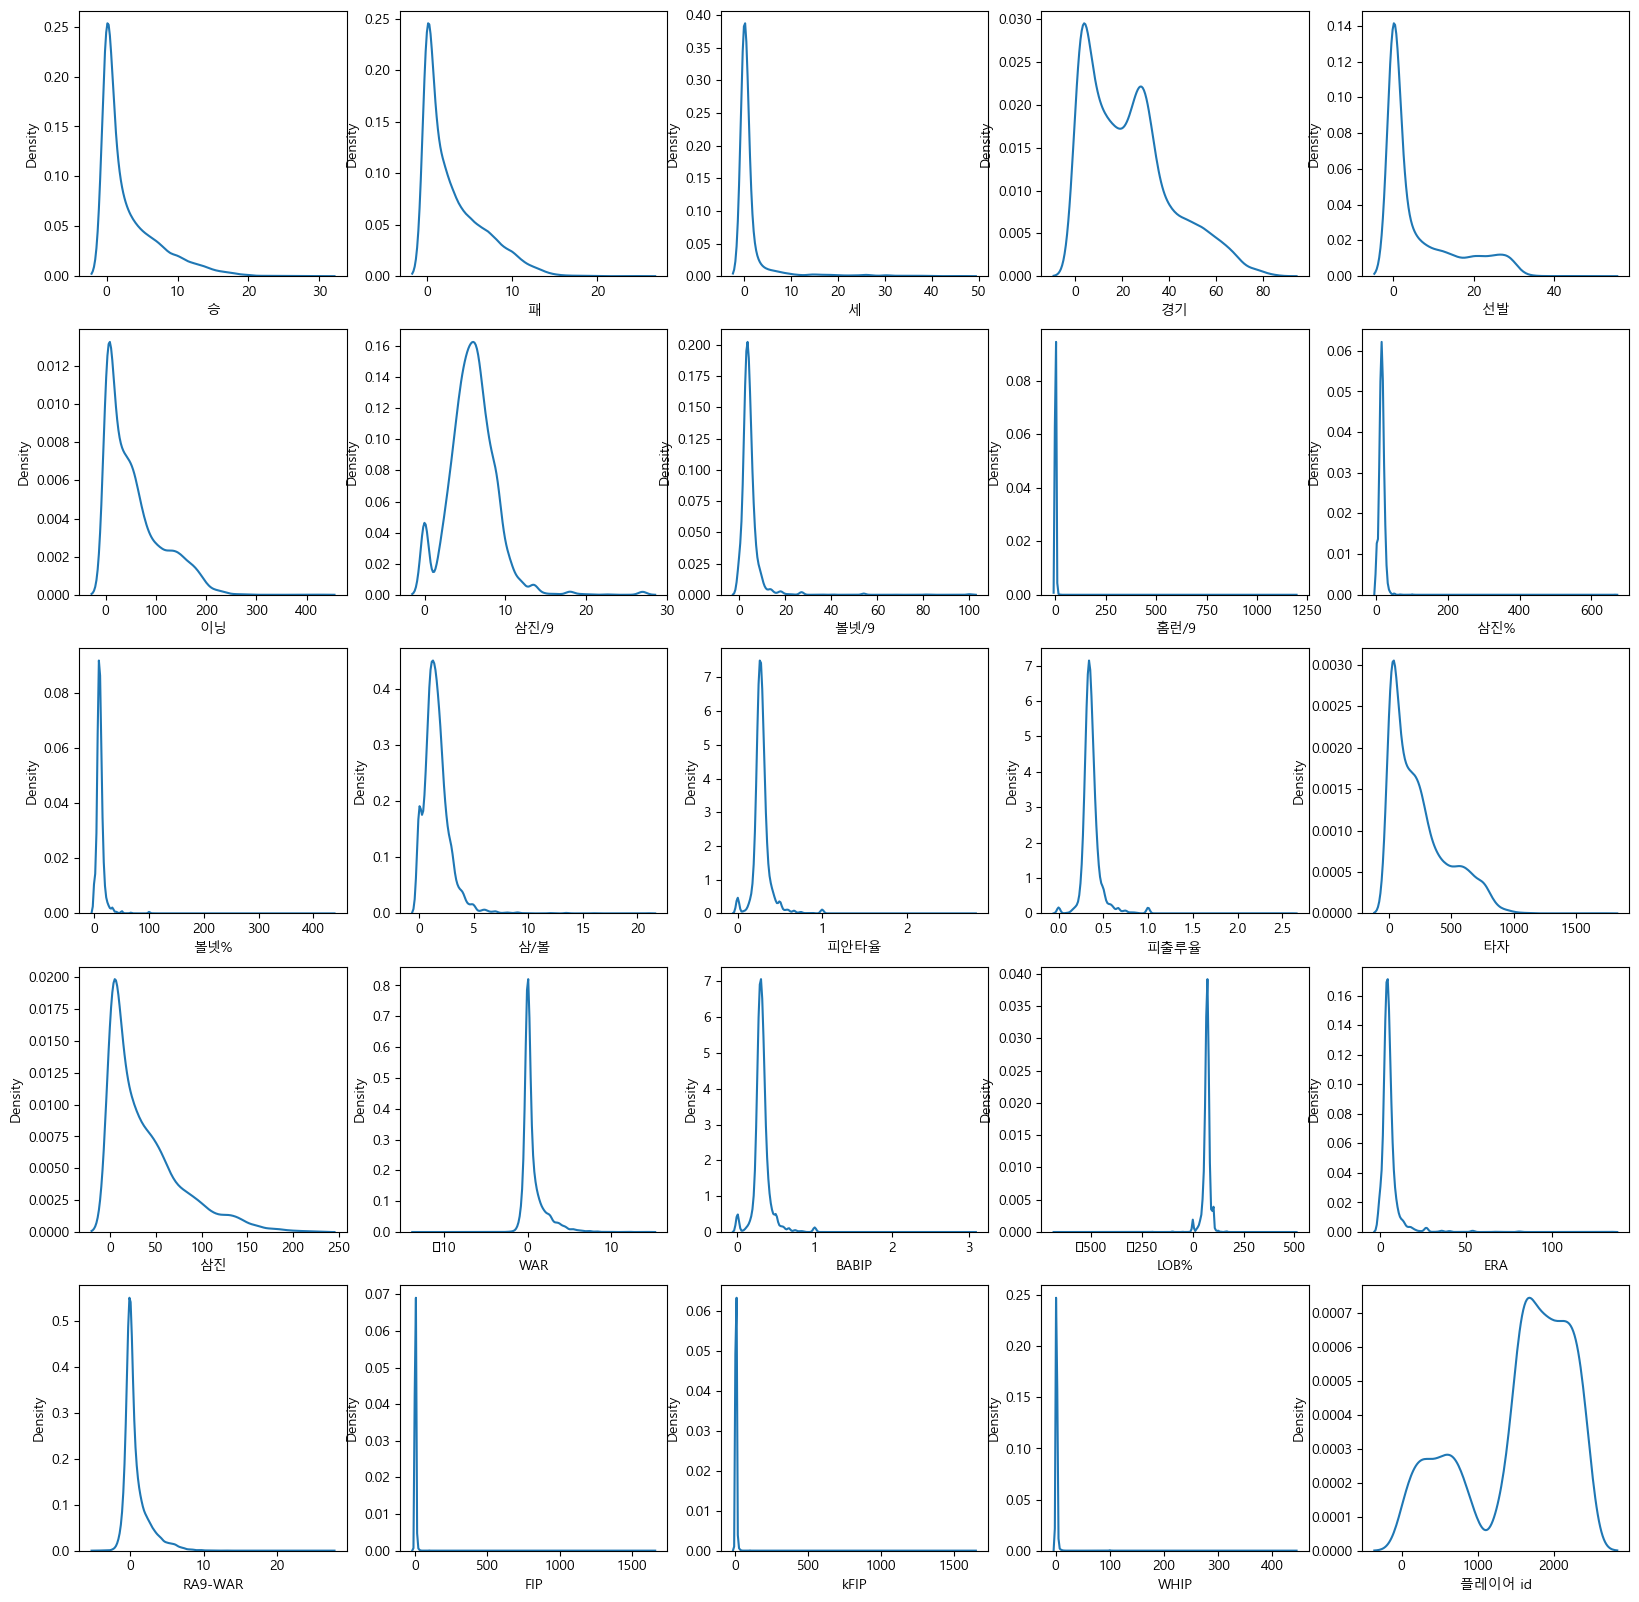

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(ncols=5,nrows=5, figsize=(20,20))
for i,column in enumerate(scaler_pd.columns[4:-1]):
    sns.kdeplot(scaler_pd[column],ax = ax[i//5][i%5])

In [67]:
# 연봉을 2022년 물가로 계산
for year in range(1987,2022):
    if len(scaler_pd.loc[scaler_pd["기록년도"]==year,"연봉"]) > 0:
        print(inflationRate_list[year-1987:])
        for rate in inflationRate_list[year-1987:]:
            scaler_pd.loc[scaler_pd["기록년도"]==year,"연봉"] = scaler_pd.loc[scaler_pd["기록년도"]==year,"연봉"] * (100 + float(rate)) / 100

5        2.8
4.3        3
9.2      7.1
11       5.7
14.5     8.6
16.4     9.3
10.5     6.2
7.7      4.8
7.9      6.3
7.9.1    4.5
7.6      4.9
5.3      4.4
5.2      7.5
-1       0.8
2        2.3
3.1      4.1
3.7      2.8
4.5      3.5
4.1      3.6
3.2      2.8
3        2.2
3.1.1    2.5
4.7      4.7
2.8      2.8
2.2      2.9
3.7.1    4.0
1.1      2.2
1.6      1.3
1.7      1.3
1.9      0.7
2.7      1.0
2.5      1.9
2.5.1    1.5
1.9.1    0.4
1.2      0.5
2.6      2.5
5.4      5.1
Name: 총지수, dtype: object
4.3        3
9.2      7.1
11       5.7
14.5     8.6
16.4     9.3
10.5     6.2
7.7      4.8
7.9      6.3
7.9.1    4.5
7.6      4.9
5.3      4.4
5.2      7.5
-1       0.8
2        2.3
3.1      4.1
3.7      2.8
4.5      3.5
4.1      3.6
3.2      2.8
3        2.2
3.1.1    2.5
4.7      4.7
2.8      2.8
2.2      2.9
3.7.1    4.0
1.1      2.2
1.6      1.3
1.7      1.3
1.9      0.7
2.7      1.0
2.5      1.9
2.5.1    1.5
1.9.1    0.4
1.2      0.5
2.6      2.5
5.4      5.1
Name: 총지수, dtype: object
9

In [69]:
scaler_pd

,#,기록년도,선수명,팀명,승,패,세,경기,선발,이닝,...,WAR,BABIP,LOB%,ERA,RA9-WAR,FIP,kFIP,WHIP,플레이어 id,연봉
0,1,1982,박철순,OB,24.0,4.0,7.0,36.0,32.0,224.7,...,5.97,0.213,76.6,1.84,9.52,2.80,2.83,0.97,1877,0.0
1,2,1982,황규봉,삼성,15.0,11.0,11.0,47.0,38.0,222.3,...,5.88,0.252,70.6,2.47,6.49,2.70,2.68,1.00,2467,0.0
2,3,1982,노상수,롯데,14.0,19.0,2.0,44.0,30.0,232.3,...,5.21,0.277,72.4,2.94,4.77,2.90,3.03,1.18,1747,0.0
3,4,1982,하기룡,MBC,13.0,10.0,9.0,43.0,29.0,191.7,...,4.54,0.254,74.5,2.30,5.49,2.86,2.96,1.11,2434,0.0
4,5,1982,선우대영,OB,7.0,6.0,0.0,27.0,8.0,138.0,...,3.27,0.291,67.6,3.39,2.49,2.96,2.97,1.23,1932,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6621,196,2021,김대우,삼성,0.0,2.0,0.0,31.0,4.0,51.0,...,-0.04,0.333,61.2,6.35,-0.23,5.00,5.13,1.63,267,0.0
6622,197,2021,김태형,LG,0.0,0.0,0.0,2.0,0.0,1.0,...,-0.04,0.000,0.0,27.00,-0.09,10.33,11.77,2.00,1599,0.0
6623,198,2021,문용익,삼성,2.0,0.0,0.0,22.0,0.0,22.0,...,-0.04,0.286,75.5,4.50,0.43,4.88,4.83,1.41,1935,0.0
6624,199,2021,홍민기,롯데,0.0,0.0,0.0,1.0,0.0,0.1,...,-0.04,0.000,50.0,27.00,-0.05,21.33,25.35,6.00,1963,0.0


In [70]:
# 결측치 수정 및 숫자 데이터 형태 float로 변경
for column in ['승', '패', '세', '경기', '선발', '이닝', '삼진/9',
       '볼넷/9', '홈런/9', '삼진%', '볼넷%', '삼/볼', '피안타율', '피출루율', '타자', '삼진', 'WAR',
       'BABIP', 'LOB%', 'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WHIP',"연봉"]:
    scaler_pd.loc[scaler_pd[column]=="-",column] = 0
    scaler_pd[column] =scaler_pd[column].astype(float)

In [71]:
# 데이터 스케일링(연봉은 2015부터 2020년 데이터만 스케일링)
from sklearn.preprocessing import *
standardScaler = StandardScaler()
for year in range(1982,2022):
    for column in ['승', '패', '세', '경기', '선발', '이닝', '삼진/9',
       '볼넷/9', '홈런/9', '삼진%', '볼넷%', '삼/볼', '피안타율', '피출루율', '타자', '삼진', 'WAR',
       'BABIP', 'LOB%', 'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WHIP']:
        if len(scaler_pd[(scaler_pd["기록년도"]==year)]) > 0 :
            standardScaler = StandardScaler()
            standardScaler.fit(scaler_pd[(scaler_pd["기록년도"]==year)][[column]])
            scaler_pd.loc[(scaler_pd["기록년도"]==year),column]=standardScaler.transform(scaler_pd[(scaler_pd["기록년도"]==year)][[column]])
robustScaler = RobustScaler()
robustScaler.fit(scaler_pd.loc[scaler_pd["연봉"]!=0,["연봉"]])
scaler_pd.loc[(scaler_pd["연봉"]!=0)&(scaler_pd["기록년도"]>2014),["연봉"]] = robustScaler.transform(scaler_pd.loc[(scaler_pd["연봉"]!=0)&(scaler_pd["기록년도"]>2014),["연봉"]])

<Axes: xlabel='연봉', ylabel='Density'>

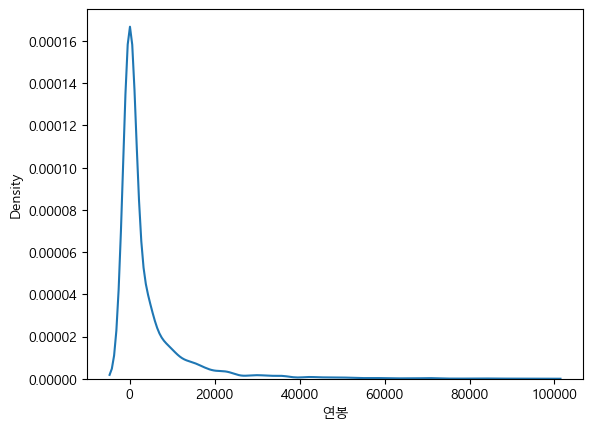

In [72]:
sns.kdeplot(scaler_pd["연봉"])

C:\Users\User\anaconda3\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
C:\Users\User\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


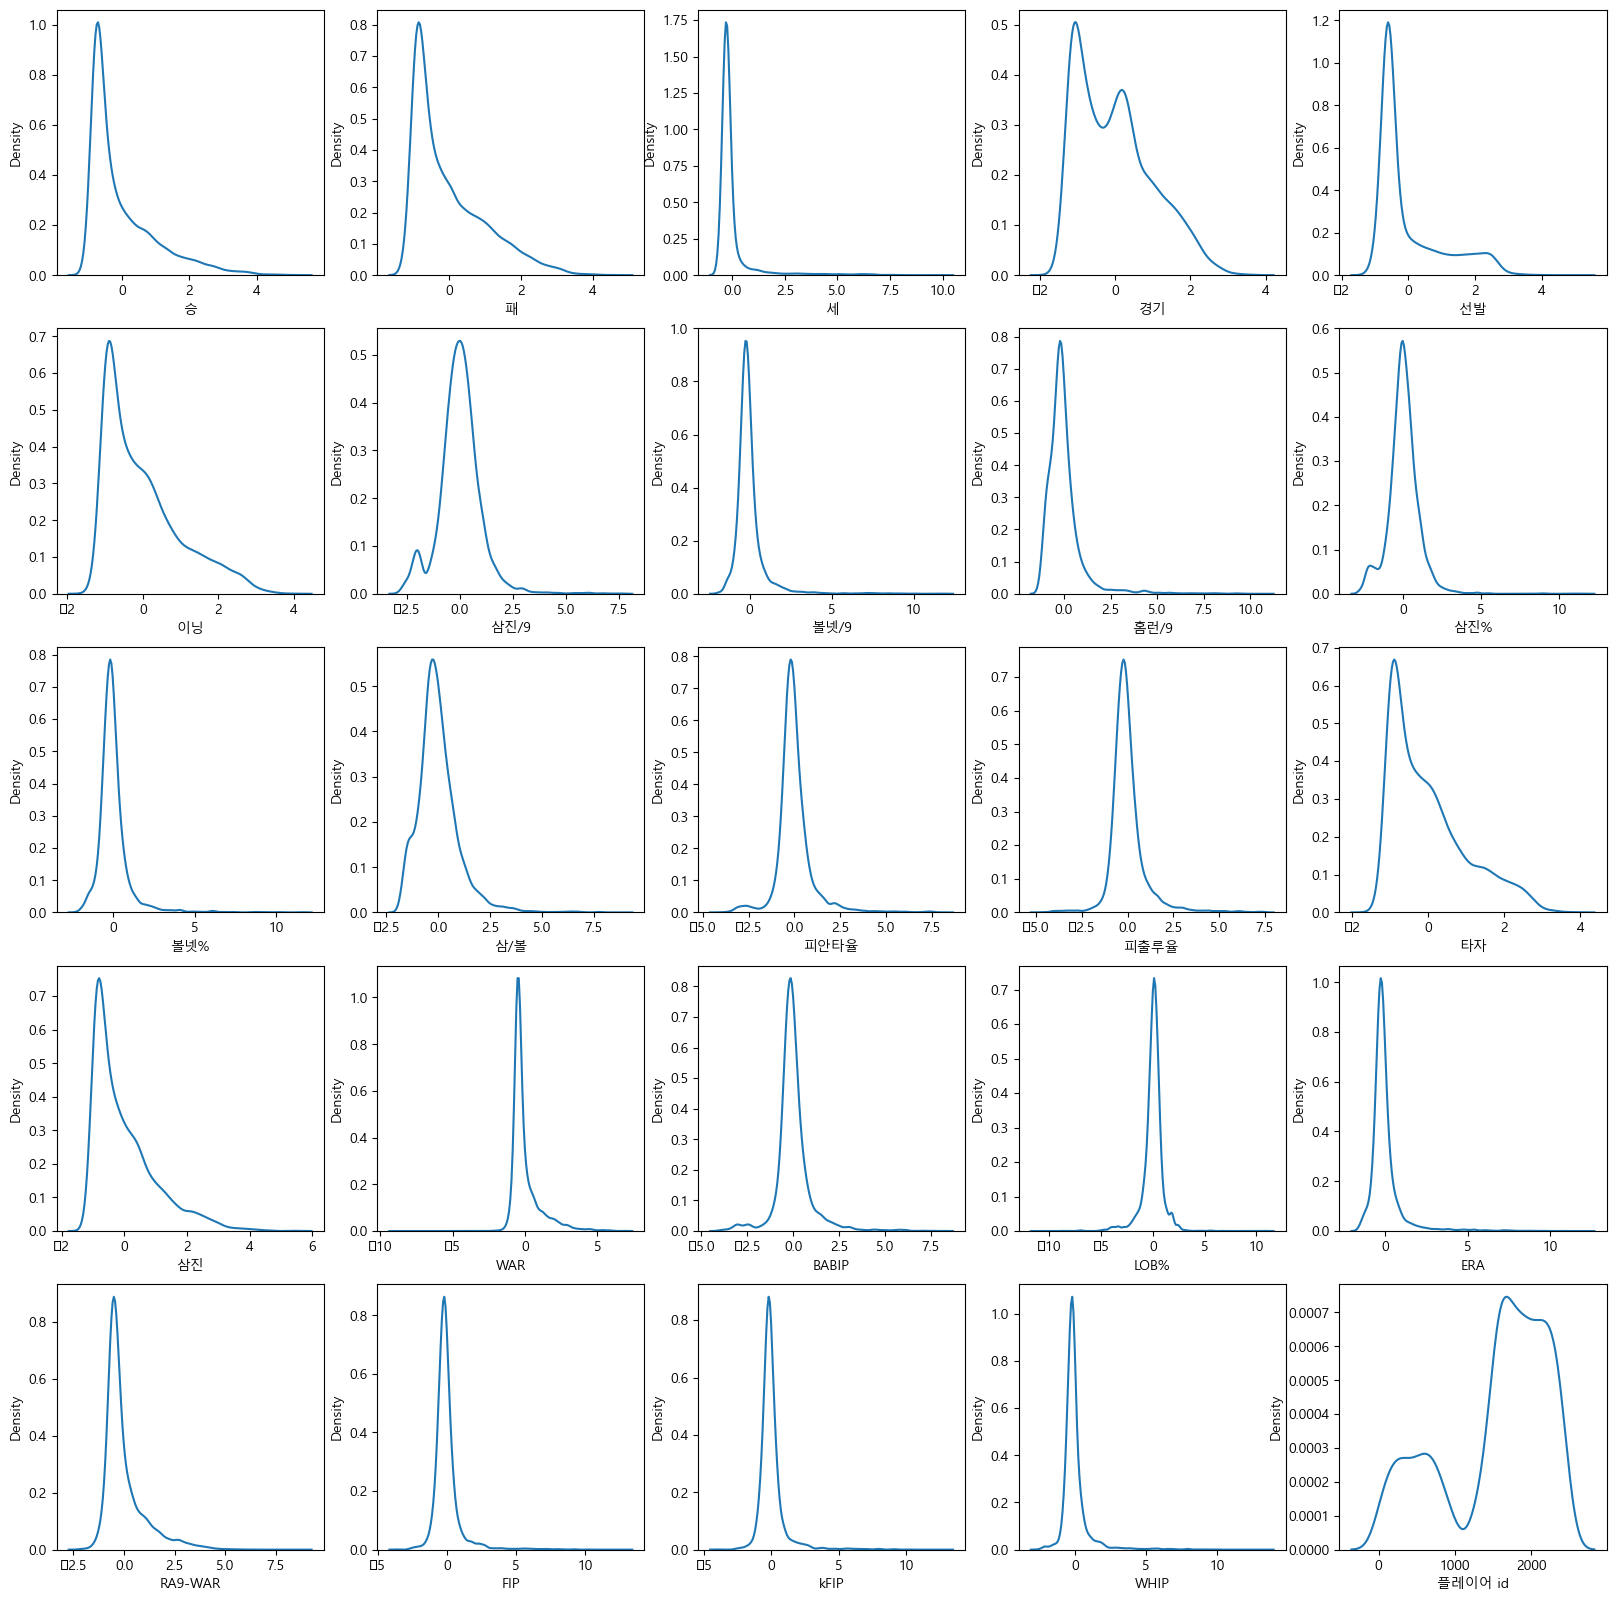

In [73]:
#robustscaler
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(ncols=5,nrows=5, figsize=(20,20))
for i,column in enumerate(scaler_pd.columns[4:-1]):
    sns.kdeplot(scaler_pd[column],ax = ax[i//5][i%5])

C:\Users\User\anaconda3\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
C:\Users\User\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


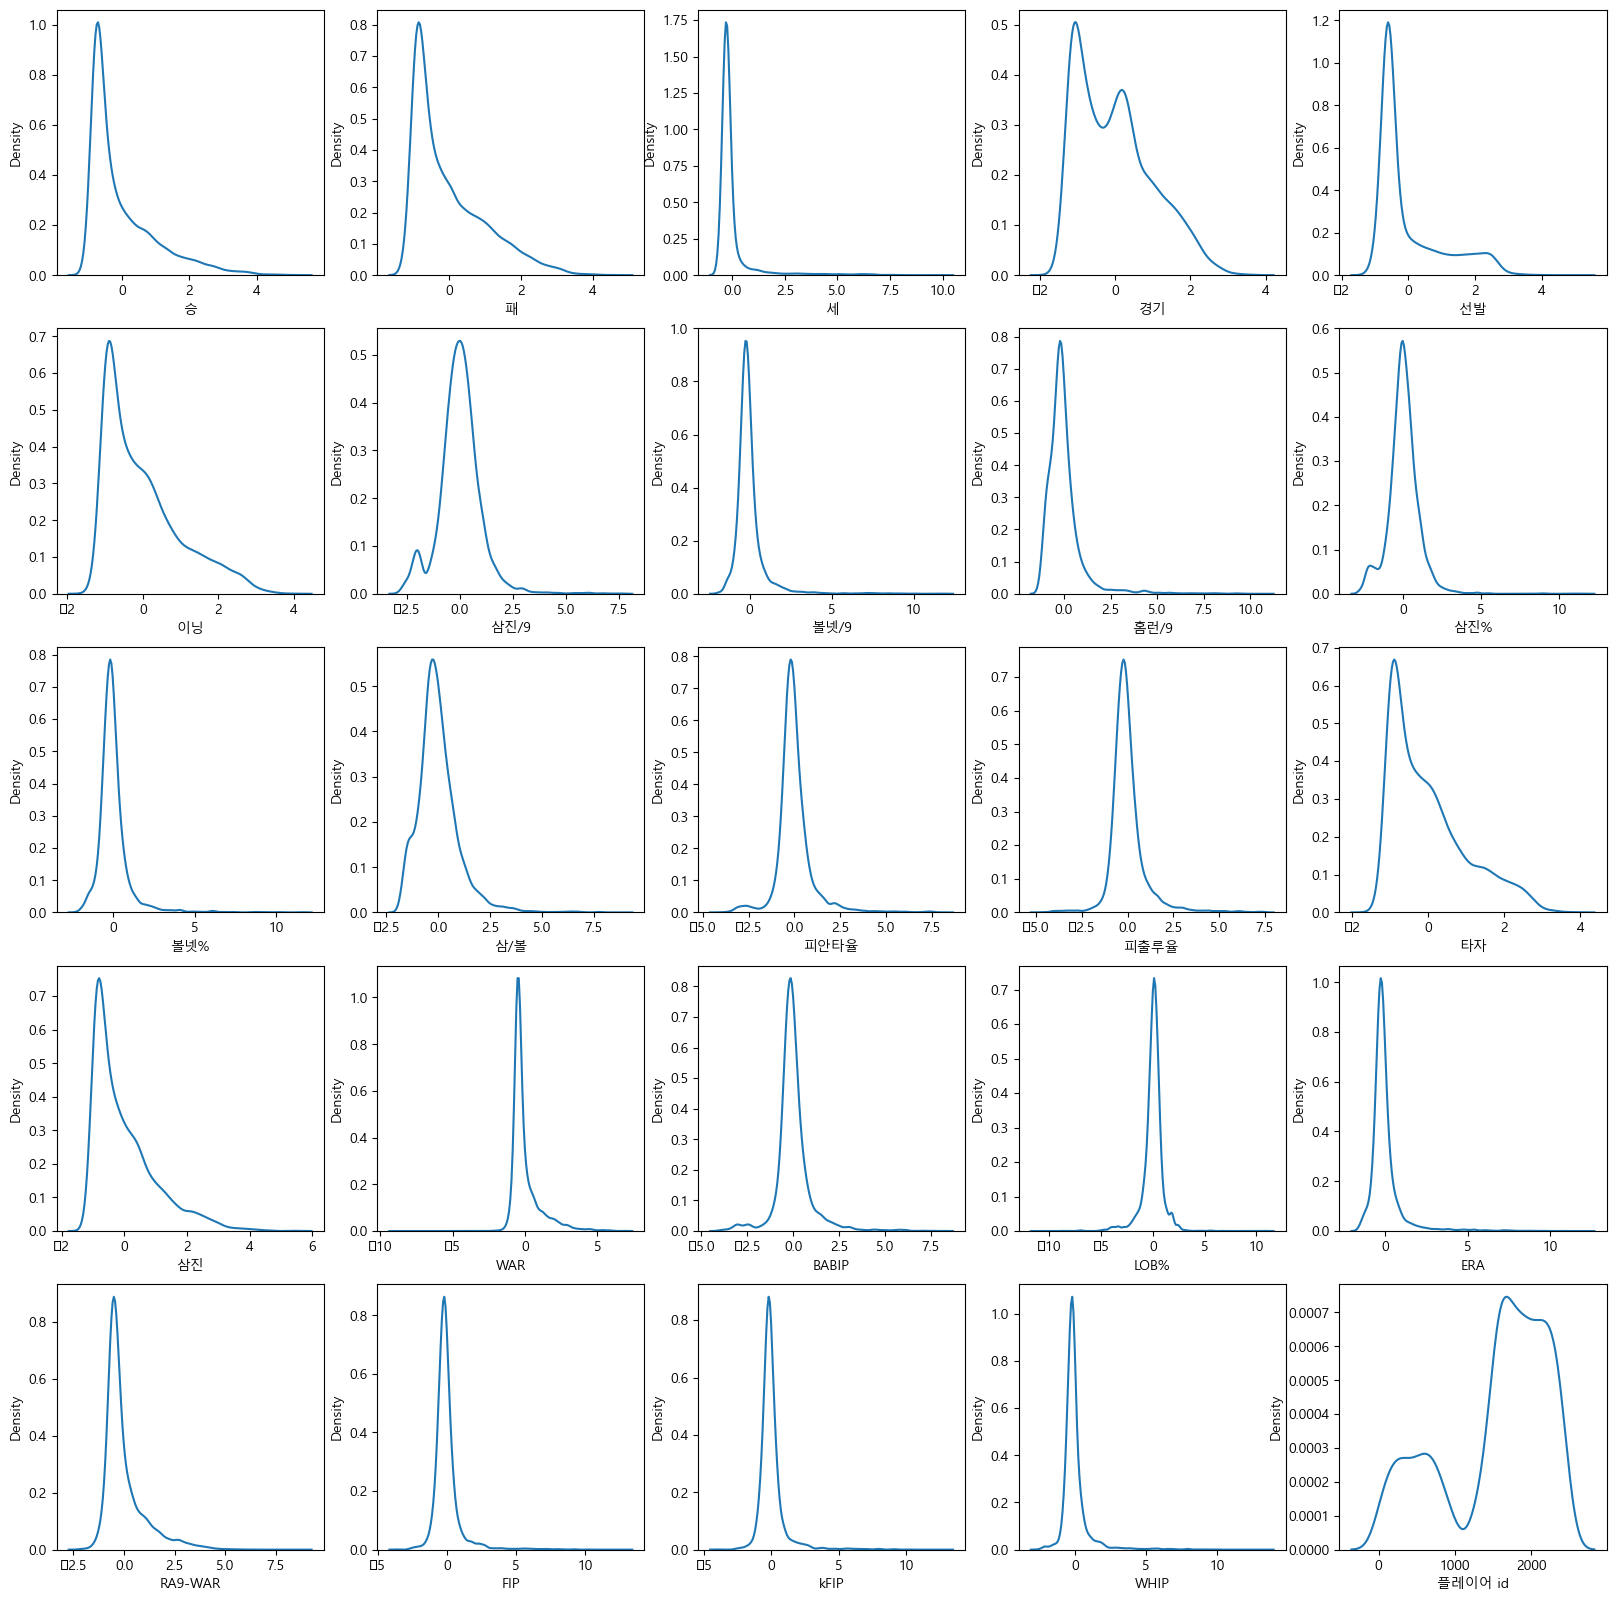

In [74]:
# MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(ncols=5,nrows=5, figsize=(20,20))
for i,column in enumerate(scaler_pd.columns[4:-1]):
    sns.kdeplot(scaler_pd[column],ax = ax[i//5][i%5])

C:\Users\User\anaconda3\lib\site-packages\IPython\core\events.py:89: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  func(*args, **kwargs)
C:\Users\User\anaconda3\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


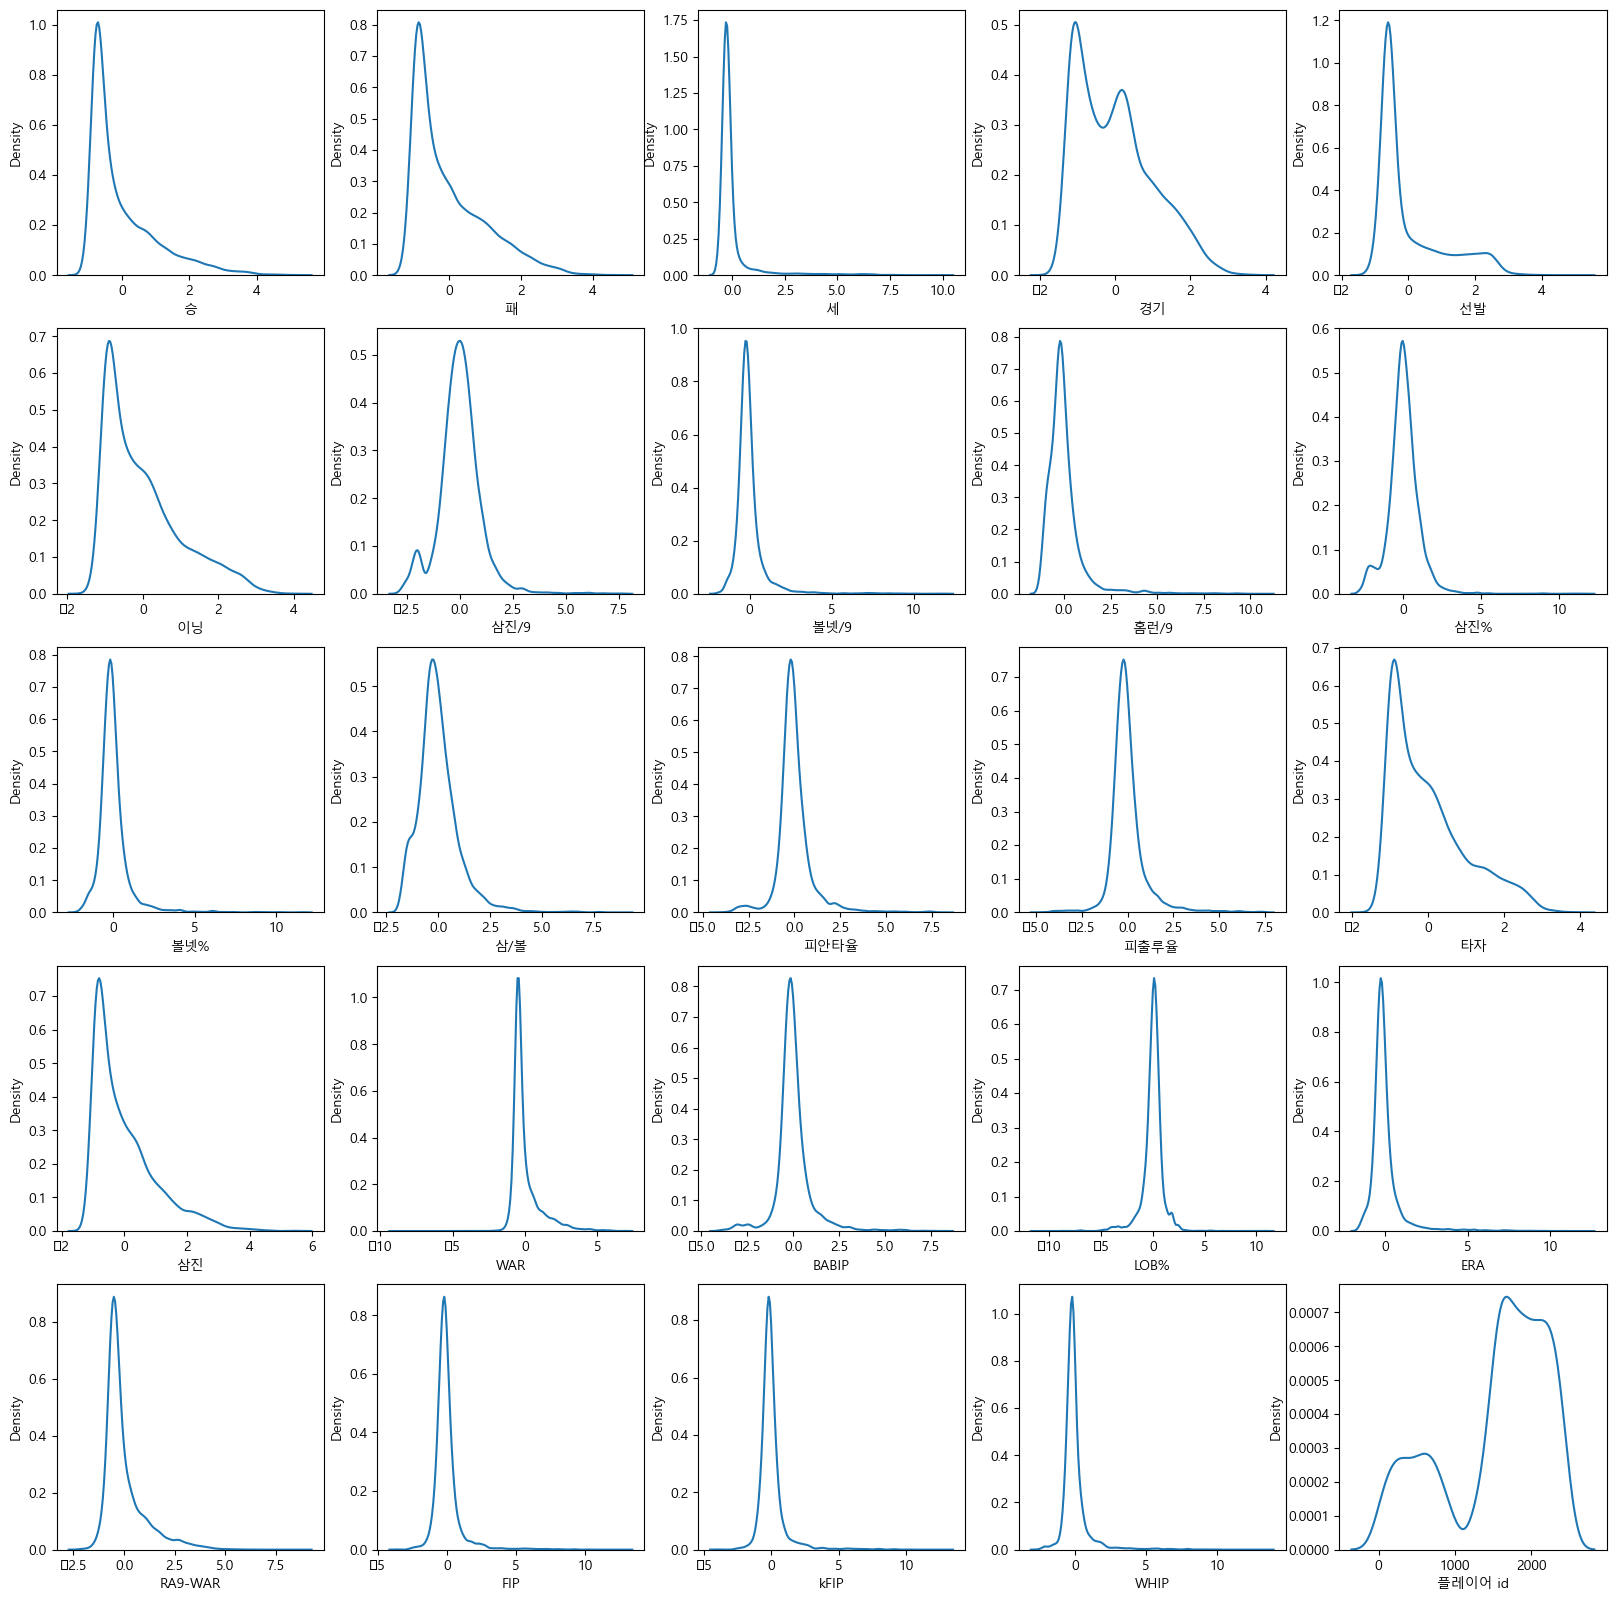

In [75]:
#StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(ncols=5,nrows=5, figsize=(20,20))
for i,column in enumerate(scaler_pd.columns[4:-1]):
    sns.kdeplot(scaler_pd[column],ax = ax[i//5][i%5])

In [76]:
year_playTime_list= {1982:80,1983:100,1984:100,1985:110,1986:108,1987:108,1988:108,1989:120,1990:120,1991:126,1992:126,1993:126,1994:126,1995:126,1996:126,1997:126,1998:126,1999:132,2000:133,2001:133,2002:133,2003:133,2004:133,2005:126,2006:126,2007:126,2008:126,2009:133,2010:133,2011:133,2012:133,2013:128,2014:128,2015:144,2016:144,2017:144,2018:144,2019:144,2020:144,2021:144}
print(len(year_playTime_list))

40


In [77]:
startingPitcher_hasSalary_pd = pd.DataFrame(columns=all_pitcher_data_pd.columns)
for year, time in year_playTime_list.items():
    year_startingPitcher_data = scaler_pd[(all_pitcher_data_pd["연봉"] != 0) & (all_pitcher_data_pd["기록년도"] == year) & (all_pitcher_data_pd["이닝"] >= time)]
    startingPitcher_hasSalary_pd = pd.concat([startingPitcher_hasSalary_pd,year_startingPitcher_data])

In [78]:
all_pitcher_data_pd.loc[all_pitcher_data_pd["선수명"]=="최동원"]

,#,기록년도,선수명,팀명,승,패,세,경기,선발,이닝,...,WAR,BABIP,LOB%,ERA,RA9-WAR,FIP,kFIP,WHIP,플레이어 id,연봉
46,4,1983,최동원,롯데,9.0,16.0,4.0,38.0,29.0,208.7,...,5.43,0.297,72.5,2.89,2.45,2.29,2.53,1.21,2366,3000.0
98,1,1984,최동원,롯데,27.0,13.0,6.0,51.0,42.0,284.7,...,8.43,0.267,77.0,2.40,6.18,1.99,2.25,1.04,2366,7400.0
157,1,1985,최동원,롯데,20.0,9.0,8.0,42.0,35.0,225.0,...,9.43,0.257,76.0,1.92,7.33,1.56,1.79,0.94,2366,8100.0
227,2,1986,최동원,롯데,19.0,14.0,2.0,39.0,21.0,267.0,...,11.84,0.268,80.3,1.55,9.01,1.20,1.49,0.97,2366,8910.0
315,1,1987,최동원,롯데,14.0,12.0,2.0,32.0,25.0,224.0,...,8.14,0.318,74.2,2.81,4.78,1.96,2.24,1.25,2366,8910.0
405,3,1988,최동원,롯데,7.0,3.0,3.0,16.0,4.0,83.3,...,3.73,0.317,80.9,2.05,2.51,1.48,2.00,1.21,2366,8910.0
589,95,1989,최동원,삼성,1.0,2.0,0.0,8.0,4.0,30.0,...,-0.22,0.327,82.4,2.10,0.48,4.96,4.79,1.80,2366,0.0
725,112,1990,최동원,삼성,6.0,5.0,1.0,22.0,15.0,92.0,...,-0.77,0.314,68.4,5.28,-0.74,5.35,5.14,1.82,2366,0.0


In [79]:
startingPitcher_hasSalary_pd= startingPitcher_hasSalary_pd[startingPitcher_hasSalary_pd["기록년도"] >= 2015]

In [80]:
for column in ['승', '패', '세', '경기', '선발', '이닝', '삼진/9',
       '볼넷/9', '홈런/9', '삼진%', '볼넷%', '삼/볼', '피안타율', '피출루율', '타자', '삼진', 'WAR',
       'BABIP', 'LOB%', 'ERA', 'RA9-WAR', 'FIP', 'kFIP', 'WHIP',"연봉"]:
    startingPitcher_hasSalary_pd.loc[startingPitcher_hasSalary_pd[column]=="-",column] = 0
    startingPitcher_hasSalary_pd[column] =startingPitcher_hasSalary_pd[column].astype(float)

In [81]:
has_salary_data_pd = scaler_pd.loc[(scaler_pd["연봉"]!=0) & (scaler_pd["기록년도"] > 2014)]

In [82]:
# 각 컬럼별 상관계수 측정
has_salary_data_pd.corr()["연봉"]

C:\Users\User\AppData\Local\Temp\ipykernel_37452\1120086274.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  has_salary_data_pd.corr()["연봉"]


#         -0.508343
기록년도            NaN
승          0.577013
패          0.563287
세          0.156105
경기         0.168870
선발         0.560488
이닝         0.588388
삼진/9       0.080819
볼넷/9      -0.154946
홈런/9      -0.006770
삼진%        0.143668
볼넷%       -0.167458
삼/볼        0.298959
피안타율      -0.007345
피출루율      -0.135568
타자         0.587324
삼진         0.576617
WAR        0.563955
BABIP      0.011732
LOB%       0.085199
ERA       -0.081690
RA9-WAR    0.519801
FIP       -0.143319
kFIP      -0.151129
WHIP      -0.117481
플레이어 id    0.120186
연봉         1.000000
Name: 연봉, dtype: float64

In [83]:
X = has_salary_data_pd[['승','선발','타자',"이닝","삼진","WAR"]]
y= has_salary_data_pd["연봉"]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

In [84]:
X_train = X_train[['승','선발','타자',"이닝","삼진","WAR"]]

In [85]:
### GBR 모델 test
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.linear_model import LassoCV , ElasticNetCV , RidgeCV

lr = GBR()
model = lr.fit(X_train, y_train)

In [86]:
from sklearn.metrics import mean_absolute_error
y_predictions = model.predict(X_train)
print(sqrt(mean_absolute_error(y_train, y_predictions))) # train RMSE score를 출력
y_predictions = model.predict(X_test)
print(sqrt(mean_absolute_error(y_test, y_predictions))) # test RMSE score를 출력

0.5667877497015029
0.9646379619541581


In [87]:
import statsmodels.api as sm

# statsmodel 라이브러리로 회귀 분석을 수행한다.
X_train = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     연봉   R-squared:                       0.431
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     19.45
Date:                Tue, 30 May 2023   Prob (F-statistic):           8.15e-17
Time:                        02:13:38   Log-Likelihood:                -336.90
No. Observations:                 161   AIC:                             687.8
Df Residuals:                     154   BIC:                             709.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0323      0.159      6.476      0.000       0.717       1.347
승              0.8033      0.436      1.843      0.067      -0.058       1.664
선발             0.2087      0.380      0.549      0.584      -0.543       0.960
타자             7.2430      3.337      2.171      0.031       0.652      13.834
이닝            -7.2255      3.493     -2.069      0.040     -14.125      -0.326
삼진            -0.2273      0.734     -0.310      0.757      -1.677       1.222
WAR            0.9041      0.403      2.246      0.026       0.109       1.699
==============================================================================
Omnibus:                      113.284   Durbin-Watson:                   1.907
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1099.517
Skew:                           2.460   Prob(JB):                    1.75e-239
Kurtosis:                      14.820   Cond. No.                         77.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 401, in fit
    Xt = self._fit(X, y, **fit_params_steps)
  File "C:\Users\User\anaconda3\lib\site-packages\sklearn\pipeline.py", line 359, in _fit
    X, fitted_transformer = fit_transform_one_cached(
  File "C:\Users\User\anaconda3\lib\

finish
{'Linear': {'fit__fit_intercept': True, 'poly__degree': 1}, 'Lasso': {'fit__alpha': 0.1, 'fit__tol': 0.07742636826811278, 'poly__degree': 1}, 'pca regression': {'pca__n_components': 2}, 'Ridge': {'fit__alpha': 5.0, 'fit__solver': 'lsqr', 'fit__tol': 0.07742636826811278, 'poly__degree': 1}, 'PLSRegression': {'fit__n_components': 2}, 'GradientDescentRegressor': {'fit__loss': 'huber', 'fit__max_depth': 6, 'fit__max_features': 'log2', 'fit__min_samples_split': 0.9}, 'RandomForestRegressor': {'fit__max_depth': 6, 'fit__max_features': 'sqrt', 'fit__min_samples_split': 0.5}, 'SupportVectorRegressor': {'fit__degree': 2, 'fit__gamma': 1e-05, 'fit__kernel': 'linear'}, 'Kernel RidgeRegression': {'fit__gamma': 0.021544346900318822, 'fit__kernel': 'rbf'}}


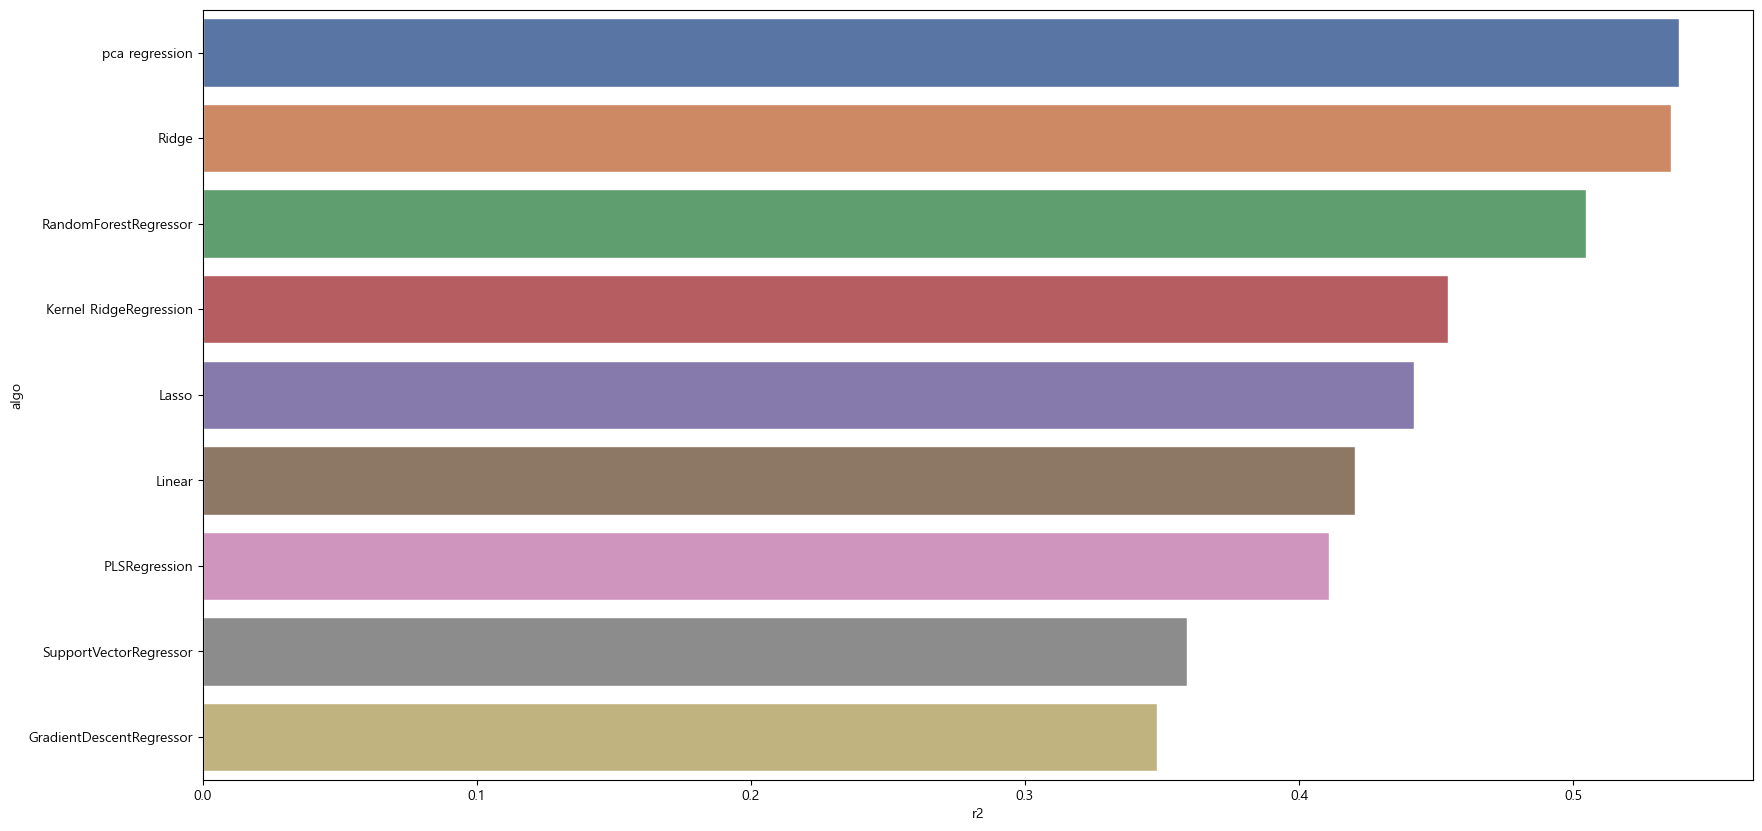

In [111]:
# 각 모델 별로 파이프라인을 구성하고 테스트 할 각 모델의 파라미터 범위를 넣고 테스트
# 그 결과 RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.linear_model import LassoCV , ElasticNetCV , RidgeCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor as GBR
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.cross_decomposition import PLSRegression as  PLS
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import ShuffleSplit,GridSearchCV
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)


cv = ShuffleSplit(n_splits=5 , test_size=0.3, random_state=42)
pipe_linear = Pipeline([
                ('poly', PolynomialFeatures()),
                 ('fit', LinearRegression())])
pipe_lasso = Pipeline([
                ('poly', PolynomialFeatures()),
                 ('fit', Lasso(random_state = 42))])
pipe_ridge = Pipeline([
                ('poly', PolynomialFeatures()),
                 ('fit', Ridge(random_state = 42))])
pipe_pca = Pipeline([
                ('pca', PCA()),
                 ('fit', Ridge(random_state = 42))])
pipe_pls = Pipeline([
                 ('fit', PLS())])
pipe_gbr = Pipeline([
                 ('fit', GBR())])
pipe_rfr = Pipeline([
                 ('fit', RFR())])
pipe_svr = Pipeline([
                 ('fit', SVR())])

pipe_KR = Pipeline([
                 ('fit', KernelRidge())])

grid_params_linear = [{
    "poly__degree" : np.arange(1,3),
    "fit__fit_intercept" : [True, False],
}]
grid_params_lasso = [{
    "poly__degree" : np.arange(1,3),
    "fit__tol" : np.logspace(-5,0,10) ,
    "fit__alpha" : np.logspace(-5,1,10) ,
                     }]
grid_params_pca = [{
    "pca__n_components" : np.arange(2,8)
}]
grid_params_ridge = [{
    "poly__degree" : np.arange(1,3),
    "fit__alpha" : np.linspace(2,5,10) ,
    "fit__solver" : [ "cholesky","lsqr","sparse_cg"] ,
    "fit__tol" : np.logspace(-5,0,10) ,
                     }]
grid_params_pls = [{
    "fit__n_components" : np.arange(2,8)
}]
min_samples_split_range = [0.5, 0.7 , 0.9]

grid_params_gbr =[{
    "fit__max_features" : ["sqrt","log2"] ,
    "fit__loss" : ["ls","lad","huber","quantile"] ,
    "fit__max_depth" : [5,6,7,8] ,
    "fit__min_samples_split" : min_samples_split_range ,
}]
grid_params_rfr =[{
    "fit__max_features" : ["sqrt","log2"] ,
    "fit__max_depth" : [5,6,7,8] ,
    "fit__min_samples_split" : min_samples_split_range ,
}]
grid_params_svr =[{
    "fit__kernel" : ["rbf", "linear"] ,
    "fit__degree" : [2, 3, 5] ,
    "fit__gamma" : np.logspace(-5,1,10) ,
}]
grid_params_KR =[{
    "fit__kernel" : ["rbf","linear"] ,
    "fit__gamma" : np.logspace(-5,1,10) ,
}]
pipe = [
    pipe_linear , pipe_lasso ,  pipe_pca ,
    pipe_ridge , pipe_pls , pipe_gbr ,
    pipe_rfr , pipe_svr , pipe_KR
]

params = [
    grid_params_linear , grid_params_lasso , grid_params_pca,
    grid_params_ridge , grid_params_pls , grid_params_gbr ,
    grid_params_rfr , grid_params_svr , grid_params_KR
]

jobs = 20

grid_dict = {
    0: 'Linear',
    1: 'Lasso',
    2: 'pca regression' ,
    3: 'Ridge' ,
    4: 'PLSRegression',
    5: "GradientDescentRegressor" ,
    6: "RandomForestRegressor" ,
    7: "SupportVectorRegressor" ,
    8: "Kernel RidgeRegression"
            }

model_mse = {}
model_r2 = {}
model_best_params = {}

for idx , (param , model) in enumerate(zip(params , pipe)) :
    search = GridSearchCV(model, param ,
                          cv=cv , n_jobs=jobs , verbose=-1 )
    search.fit(X_train , y_train)
    y_pred = search.predict(X_test)
    model_mse[grid_dict.get(idx)] = mse(y_test, y_pred)
    model_r2[grid_dict.get(idx)] = r2(y_test, y_pred)
    model_best_params[grid_dict.get(idx)] = search.best_params_
print("finish")
print(model_best_params)

fig ,ax = plt.subplots(figsize=(20, 10))
sns.set(font_scale = 2)
output = pd.DataFrame([model_r2.keys() , model_r2.values()], index = ["algo","r2"]).T
output.sort_values(["r2"], ascending= False ,inplace=True)
ax = sns.barplot(y="algo", x="r2", data=output)
plt.show()

In [112]:
lr = RFR(max_depth=6, max_features='sqrt', min_samples_split=0.5)
model = lr.fit(X_train, y_train)

In [113]:
from sklearn.metrics import mean_absolute_error
y_predictions = model.predict(X_train)
print(sqrt(mean_absolute_error(y_train, y_predictions))) # train RMSE score를 출력
y_predictions = model.predict(X_test)
print(sqrt(mean_absolute_error(y_test, y_predictions))) # test RMSE score를 출력

1.062664901047516
0.9579445866635876


In [114]:
choi_salary_pd = pd.DataFrame(columns=list(range(1983,1991)))
choi_salary_pd.loc[0] =robustScaler.inverse_transform(model.predict(scaler_pd.loc[scaler_pd["선수명"]=="최동원",['승','선발','타자',"이닝","삼진","WAR"]]).reshape(1,-1)).reshape(-1).tolist()
choi_salary_pd.rename(index={0:"연봉"},inplace=True)

In [115]:
choi_salary_pd

,1983,1984,1985,1986,1987,1988,1989,1990
연봉,46673.064773,54067.846494,53616.393024,53290.336678,53222.015967,39041.403242,7700.271397,30386.420158
